The following data sets are of two solar power plants in India over a period of 34 days. For each solar power plant there are two files, one representing the power generation and the other shows the sensor reading. 

The power generation datasets are gathered at inverter level where each inverter has multiple lines of solar panels attached to it. The sensor data is gathered at a plant level. A single array of sensors are optimally placed at the plant.

This notebook will attempt to answer the following questions:

1. Can we predict the power generation for next couple of days? 
2. Can we identify faulty or suboptimally performing equipment?


In [1]:
# import modules
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import os
import inspect #used to explore function 
from math import sqrt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import warnings
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.arima_model import ARIMA
import xgboost as xgb
import keras
from keras.models import Sequential
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import LSTM, TimeDistributed, RepeatVector, Dense, Flatten
from keras.optimizers import Adam

warnings.filterwarnings('ignore')

Using TensorFlow backend.
C:\Users\amit_\anaconda3\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\amit_\anaconda3\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\amit_\anaconda3\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\amit_\anaconda3\envs\keras\lib\site-pa

# Import Data

In [2]:
os.listdir('Data')

['Plant_1_Generation_Data.csv',
 'Plant_1_Weather_Sensor_Data.csv',
 'Plant_2_Generation_Data.csv',
 'Plant_2_Weather_Sensor_Data.csv']

In [3]:
# read in all datasets while passing the datetime as the index
plant1_gend = pd.read_csv('Data/Plant_1_Generation_Data.csv', index_col='DATE_TIME',parse_dates=True, infer_datetime_format=True)
plant1_send = pd.read_csv('Data/Plant_1_Weather_Sensor_Data.csv', index_col='DATE_TIME',parse_dates=True, infer_datetime_format=True)
plant2_gend = pd.read_csv('Data/Plant_2_Generation_Data.csv', index_col='DATE_TIME',parse_dates=True, infer_datetime_format=True)
plant2_send = pd.read_csv('Data/Plant_2_Weather_Sensor_Data.csv', index_col='DATE_TIME',parse_dates=True, infer_datetime_format=True)

In [4]:
# Check data types for the index are the same 
np.dtype('datetime64[ns]') == np.dtype('<M8[ns]')

True

# Data Cleaning

change column datatypes if needed 

In [5]:
#check for missing values within each dataframe
all_data = [plant1_gend, plant1_send, plant2_gend, plant2_send]
for data_set in all_data:
    print(f"{data_set.info()}\n")
    

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 68778 entries, 2020-05-15 00:00:00 to 2020-06-17 23:45:00
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PLANT_ID     68778 non-null  int64  
 1   SOURCE_KEY   68778 non-null  object 
 2   DC_POWER     68778 non-null  float64
 3   AC_POWER     68778 non-null  float64
 4   DAILY_YIELD  68778 non-null  float64
 5   TOTAL_YIELD  68778 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 3.7+ MB
None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3182 entries, 2020-05-15 00:00:00 to 2020-06-17 23:45:00
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PLANT_ID             3182 non-null   int64  
 1   SOURCE_KEY           3182 non-null   object 
 2   AMBIENT_TEMPERATURE  3182 non-null   float64
 3   MODULE_TEMPERATURE   3182 non-null   float64
 4   IRRADI

In [6]:
# drop PLANT_ID from dataset
plant1_send.drop('PLANT_ID', axis=1, inplace=True)

In [7]:
# check for duplicates
print(any(plant1_gend.duplicated()))
print(any(plant1_send.duplicated()))
print(any(plant2_gend.duplicated()))
print(any(plant2_send.duplicated()))

True
False
True
False


In [8]:
# find unique source keys 
print(f"Plant 1 sensor source key: {plant1_send.SOURCE_KEY.unique()}\n")
print(f"Plant 1 generation data source keys: {plant1_gend.SOURCE_KEY.unique()}")

Plant 1 sensor source key: ['HmiyD2TTLFNqkNe']

Plant 1 generation data source keys: ['1BY6WEcLGh8j5v7' '1IF53ai7Xc0U56Y' '3PZuoBAID5Wc2HD' '7JYdWkrLSPkdwr4'
 'McdE0feGgRqW7Ca' 'VHMLBKoKgIrUVDU' 'WRmjgnKYAwPKWDb' 'ZnxXDlPa8U1GXgE'
 'ZoEaEvLYb1n2sOq' 'adLQvlD726eNBSB' 'bvBOhCH3iADSZry' 'iCRJl6heRkivqQ3'
 'ih0vzX44oOqAx2f' 'pkci93gMrogZuBj' 'rGa61gmuvPhdLxV' 'sjndEbLyjtCKgGv'
 'uHbuxQJl8lW7ozc' 'wCURE6d3bPkepu2' 'z9Y9gH1T5YWrNuG' 'zBIq5rxdHJRwDNY'
 'zVJPv84UY57bAof' 'YxYtjZvoooNbGkE']


 Two different datasets are created by resampling the original data.
 
 1)  Dataset 1 which is aggregated by the mean. The source key will not be included in this as it is used for future prediction (Q1).

 2)  Dataset 2 which includes 15 minute intervals and includes the SOURCE_KEYS and is used for analysis (Q2).

<font color='red'>START OF DATASET 1 - Used for Predictions</font>

The same steps are repeated for both datasets, Solar Plant 1 (SP1) and Solar Plant 2 (SP2).

In [9]:
# For dataset 1, PLANT_ID and SOURCE_KEY are dropped from generation and SOURCE_KEY is dropped from sensor
plant1_gend_1 = plant1_gend.drop(['PLANT_ID', 'SOURCE_KEY'], axis=1)
plant1_send_1 = plant1_send.drop(['SOURCE_KEY'], axis=1)

plant2_gend_1 = plant2_gend.drop(['PLANT_ID', 'SOURCE_KEY'], axis=1)
plant2_send_1 = plant2_send.drop(['SOURCE_KEY'], axis=1)

In [10]:
# create a column for the number of SOURCE_KEYS that are being aggregated.
plant1_gend_1['num_of_SK'] = plant1_gend_1.groupby(['DATE_TIME']).size()

plant2_gend_1['num_of_SK'] = plant2_gend_1.groupby(['DATE_TIME']).size()

In [11]:
plant1_gend_1.head()

DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  num_of_SK
DATE_TIME                                                          
2020-05-15       0.0       0.0          0.0    6259559.0         21
2020-05-15       0.0       0.0          0.0    6183645.0         21
2020-05-15       0.0       0.0          0.0    6987759.0         21
2020-05-15       0.0       0.0          0.0    7602960.0         21
2020-05-15       0.0       0.0          0.0    7158964.0         21

In [12]:
# group data by date and aggregate for total power output of plant 
plant1_gend_1_agg = plant1_gend_1.groupby(['DATE_TIME']).agg({'DC_POWER':'mean',
                                                              'AC_POWER':'mean',
                                                              'DAILY_YIELD':'sum',
                                                              'TOTAL_YIELD':'sum',
                                                              'num_of_SK': 'first'})

plant2_gend_1_agg = plant2_gend_1.groupby(['DATE_TIME']).agg({'DC_POWER':'mean',
                                                              'AC_POWER':'mean',
                                                              'DAILY_YIELD':'sum',
                                                              'TOTAL_YIELD':'sum',
                                                              'num_of_SK': 'first'})

In [13]:
# outer join plant1_send_1 and plant1_gend_1_agg & plant2_send_1 and plant2_gend_1_agg
plant1_df_1 = plant1_send_1.join(plant1_gend_1_agg, how='outer')
plant2_df_1 = plant2_send_1.join(plant2_gend_1_agg, how='outer')

In [14]:
# check for missing values for plant 1.
plant1_df_1[plant1_df_1.isnull().any(axis=1)]

AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  \
DATE_TIME                                                                   
2020-05-20 23:00:00            23.830852           21.024118     0.000000   
2020-05-20 23:15:00            23.701162           20.786399     0.000000   
2020-05-20 23:30:00            23.589626           20.572882     0.000000   
2020-05-20 23:45:00            23.569009           20.622103     0.000000   
2020-05-21 00:00:00            23.497382           20.584137     0.000000   
2020-05-21 00:15:00            23.228943           20.230347     0.000000   
2020-05-21 00:30:00            23.204518           20.179942     0.000000   
2020-05-23 05:15:00            21.900024           20.994995     0.000000   
2020-05-25 05:45:00            22.930503           21.104395     0.001908   
2020-05-28 22:30:00            21.259225           20.277036     0.000000   
2020-05-28 22:45:00            21.242074           20.330682     0.000000   
2020-05-28 23:00:00            21.212694           20.339630     0.000000   
2020-05-28 23:15:00            21.195797           20.363869     0.000000   
2020-05-28 23:30:00            21.199087           20.352065     0.000000   
2020-05-28 23:45:00            21.157243           20.267047     0.000000   
2020-05-29 00:00:00            21.095442           20.236613     0.000000   
2020-05-29 00:15:00            21.076190           20.206651     0.000000   
2020-05-29 00:30:00            21.008919           20.190776     0.000000   
2020-05-29 00:45:00            20.794033           19.973201     0.000000   
2020-05-29 01:00:00            20.708745           19.866868     0.000000   
2020-05-29 01:15:00            20.666713           19.794505     0.000000   
2020-05-29 01:30:00            20.695156           19.810478     0.000000   
2020-05-29 01:45:00            20.707138           19.799289     0.000000   
2020-06-03 14:00:00                  NaN                 NaN          NaN   
2020-06-17 06:15:00            22.093398           20.822978     0.019175   
2020-06-17 06:30:00            22.275627           21.973568     0.034624   

                     DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  num_of_SK  
DATE_TIME                                                                     
2020-05-20 23:00:00       NaN       NaN          NaN          NaN        NaN  
2020-05-20 23:15:00       NaN       NaN          NaN          NaN        NaN  
2020-05-20 23:30:00       NaN       NaN          NaN          NaN        NaN  
2020-05-20 23:45:00       NaN       NaN          NaN          NaN        NaN  
2020-05-21 00:00:00       NaN       NaN          NaN          NaN        NaN  
2020-05-21 00:15:00       NaN       NaN          NaN          NaN        NaN  
2020-05-21 00:30:00       NaN       NaN          NaN          NaN        NaN  
2020-05-23 05:15:00       NaN       NaN          NaN          NaN        NaN  
2020-05-25 05:45:00       NaN       NaN          NaN          NaN        NaN  
2020-05-28 22:30:00       NaN       NaN          NaN          NaN        NaN  
2020-05-28 22:45:00       NaN       NaN          NaN          NaN        NaN  
2020-05-28 23:00:00       NaN       NaN          NaN          NaN        NaN  
2020-05-28 23:15:00       NaN       NaN          NaN          NaN        NaN  
2020-05-28 23:30:00       NaN       NaN          NaN          NaN        NaN  
2020-05-28 23:45:00       NaN       NaN          NaN          NaN        NaN  
2020-05-29 00:00:00       NaN       NaN          NaN          NaN        NaN  
2020-05-29 00:15:00       NaN       NaN          NaN          NaN        NaN  
2020-05-29 00:30:00       NaN       NaN          NaN          NaN        NaN  
2020-05-29 00:45:00       NaN       NaN          NaN          NaN        NaN  
2020-05-29 01:00:00       NaN       NaN          NaN          NaN        NaN  
2020-05-29 01:15:00       NaN       NaN          NaN          NaN        NaN  
2020-05-29 01:30:00       NaN       NaN        

In [15]:
# check missing data for plant 2.
plant2_df_1[plant2_df_1.isnull().any(axis=1)]

Empty DataFrame
Columns: [PLANT_ID, AMBIENT_TEMPERATURE, MODULE_TEMPERATURE, IRRADIATION, DC_POWER, AC_POWER, DAILY_YIELD, TOTAL_YIELD, num_of_SK]
Index: []

In [16]:
# use forward interpolation to fill in missing values for ambient_temperature, module_temperature and irradiation for plant 1
plant1_df_1[['AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION','DAILY_YIELD']] = plant1_df_1[['AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION','DAILY_YIELD']].interpolate(method='linear',limit_direction='forward',axis=0)

In [17]:
# check remaining missing values for plant 1
plant1_df_1[plant1_df_1.isnull().any(axis=1)]

AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  \
DATE_TIME                                                                   
2020-05-20 23:00:00            23.830852           21.024118     0.000000   
2020-05-20 23:15:00            23.701162           20.786399     0.000000   
2020-05-20 23:30:00            23.589626           20.572882     0.000000   
2020-05-20 23:45:00            23.569009           20.622103     0.000000   
2020-05-21 00:00:00            23.497382           20.584137     0.000000   
2020-05-21 00:15:00            23.228943           20.230347     0.000000   
2020-05-21 00:30:00            23.204518           20.179942     0.000000   
2020-05-23 05:15:00            21.900024           20.994995     0.000000   
2020-05-25 05:45:00            22.930503           21.104395     0.001908   
2020-05-28 22:30:00            21.259225           20.277036     0.000000   
2020-05-28 22:45:00            21.242074           20.330682     0.000000   
2020-05-28 23:00:00            21.212694           20.339630     0.000000   
2020-05-28 23:15:00            21.195797           20.363869     0.000000   
2020-05-28 23:30:00            21.199087           20.352065     0.000000   
2020-05-28 23:45:00            21.157243           20.267047     0.000000   
2020-05-29 00:00:00            21.095442           20.236613     0.000000   
2020-05-29 00:15:00            21.076190           20.206651     0.000000   
2020-05-29 00:30:00            21.008919           20.190776     0.000000   
2020-05-29 00:45:00            20.794033           19.973201     0.000000   
2020-05-29 01:00:00            20.708745           19.866868     0.000000   
2020-05-29 01:15:00            20.666713           19.794505     0.000000   
2020-05-29 01:30:00            20.695156           19.810478     0.000000   
2020-05-29 01:45:00            20.707138           19.799289     0.000000   
2020-06-17 06:15:00            22.093398           20.822978     0.019175   
2020-06-17 06:30:00            22.275627           21.973568     0.034624   

                     DC_POWER  AC_POWER    DAILY_YIELD  TOTAL_YIELD  num_of_SK  
DATE_TIME                                                                       
2020-05-20 23:00:00       NaN       NaN  170416.106250          NaN        NaN  
2020-05-20 23:15:00       NaN       NaN  147062.212500          NaN        NaN  
2020-05-20 23:30:00       NaN       NaN  123708.318750          NaN        NaN  
2020-05-20 23:45:00       NaN       NaN  100354.425000          NaN        NaN  
2020-05-21 00:00:00       NaN       NaN   77000.531250          NaN        NaN  
2020-05-21 00:15:00       NaN       NaN   53646.637500          NaN        NaN  
2020-05-21 00:30:00       NaN       NaN   30292.743750          NaN        NaN  
2020-05-23 05:15:00       NaN       NaN     281.083333          NaN        NaN  
2020-05-25 05:45:00       NaN       NaN       0.000000          NaN        NaN  
2020-05-28 22:30:00       NaN       NaN  171206.326667          NaN        NaN  
2020-05-28 22:45:00       NaN       NaN  158980.653333          NaN        NaN  
2020-05-28 23:00:00       NaN       NaN  146754.980000          NaN        NaN  
2020-05-28 23:15:00       NaN       NaN  134529.306667          NaN        NaN  
2020-05-28 23:30:00       NaN       NaN  122303.633333          NaN        NaN  
2020-05-28 23:45:00       NaN       NaN  110077.960000          NaN        NaN  
2020-05-29 00:00:00       NaN       NaN   97852.286667          NaN        NaN  
2020-05-29 00:15:00       NaN       NaN   85626.613333          NaN        NaN  
2020-05-29 00:30:00       NaN       NaN   73400.940000          NaN        NaN  
2020-05-29 00:45:00       NaN       NaN   61175.266667          NaN        NaN  
2020-05-29 01:00:00       NaN       NaN   48949.593333          NaN        NaN  
2020-05-29 01:15:00       NaN       NaN   36723.920000          NaN        NaN  
2020-05-29 01:30:00       NaN       NaN   24498.246667          NaN        NaN

All other missing values will be zero as it is assumed if the data is missing the plant is under maintenance. 

In [18]:
# based of the assumption that missing values are due to the solar plant being under maintenance, all missing values are filled with 0 
plant1_df_1.fillna(0, inplace=True)

In [19]:
# create copies of the two dataframes
PLANT1_DF1 = plant1_df_1.copy()
PLANT2_DF1 = plant2_df_1.copy()

Check if any DATE_TIME index are missing. 

In [20]:
np.unique(PLANT1_DF1.index.date)

array([datetime.date(2020, 5, 15), datetime.date(2020, 5, 16),
       datetime.date(2020, 5, 17), datetime.date(2020, 5, 18),
       datetime.date(2020, 5, 19), datetime.date(2020, 5, 20),
       datetime.date(2020, 5, 21), datetime.date(2020, 5, 22),
       datetime.date(2020, 5, 23), datetime.date(2020, 5, 24),
       datetime.date(2020, 5, 25), datetime.date(2020, 5, 26),
       datetime.date(2020, 5, 27), datetime.date(2020, 5, 28),
       datetime.date(2020, 5, 29), datetime.date(2020, 5, 30),
       datetime.date(2020, 5, 31), datetime.date(2020, 6, 1),
       datetime.date(2020, 6, 2), datetime.date(2020, 6, 3),
       datetime.date(2020, 6, 4), datetime.date(2020, 6, 5),
       datetime.date(2020, 6, 6), datetime.date(2020, 6, 7),
       datetime.date(2020, 6, 8), datetime.date(2020, 6, 9),
       datetime.date(2020, 6, 10), datetime.date(2020, 6, 11),
       datetime.date(2020, 6, 12), datetime.date(2020, 6, 13),
       datetime.date(2020, 6, 14), datetime.date(2020, 6, 15),
 

Issues with Dataset_1 : There seems to be missing datetimes for 15 mins intervals. 

Create a list of datetime from intial to the end and find which dates do not appear in list.

Reason for missing dates could be the plant is under maintenance

In [21]:
def date_range(start_date, end_date, increment, period):
    """
    Function which returns a list of datetimes given an interval. 
    """
    result = []
    nxt = start_date
    delta = relativedelta(**{period:increment})
    while nxt <= end_date:
        result.append(nxt)
        nxt += delta
    return result

In [22]:
# create a list of dateranges from start of plant1_DF1 to end
date_range = date_range(datetime(2020,5,15, 0,0,0),datetime(2020,6,17,23,45,0), 15, 'minutes')

In [23]:
# show the number of missing datetimes missing in each dataframe
print(f'There are {len(date_range) - len(PLANT1_DF1.index)} missing datetimes in Plant 1.')
print(f'There are {len(date_range) - len(PLANT2_DF1.index)} missing datetimes in Plant 2.')

There are 81 missing datetimes in Plant 1.
There are 5 missing datetimes in Plant 2.


In [24]:
# The datetimes that are missing from the dataframe.
set(date_range).difference(set(PLANT1_DF1.index.tolist()))

{datetime.datetime(2020, 5, 15, 23, 15),
 datetime.datetime(2020, 5, 15, 23, 30),
 datetime.datetime(2020, 5, 15, 23, 45),
 datetime.datetime(2020, 5, 16, 0, 0),
 datetime.datetime(2020, 5, 16, 0, 15),
 datetime.datetime(2020, 5, 16, 0, 30),
 datetime.datetime(2020, 5, 16, 0, 45),
 datetime.datetime(2020, 5, 16, 1, 0),
 datetime.datetime(2020, 5, 16, 1, 15),
 datetime.datetime(2020, 5, 16, 1, 30),
 datetime.datetime(2020, 5, 16, 1, 45),
 datetime.datetime(2020, 5, 19, 11, 45),
 datetime.datetime(2020, 5, 19, 12, 0),
 datetime.datetime(2020, 5, 19, 12, 15),
 datetime.datetime(2020, 5, 20, 13, 30),
 datetime.datetime(2020, 5, 20, 13, 45),
 datetime.datetime(2020, 5, 20, 14, 0),
 datetime.datetime(2020, 5, 20, 14, 15),
 datetime.datetime(2020, 5, 20, 14, 30),
 datetime.datetime(2020, 5, 20, 14, 45),
 datetime.datetime(2020, 5, 20, 15, 0),
 datetime.datetime(2020, 5, 20, 15, 15),
 datetime.datetime(2020, 5, 20, 15, 30),
 datetime.datetime(2020, 5, 20, 15, 45),
 datetime.datetime(2020, 5, 2

In [25]:
set(date_range).difference(set(PLANT2_DF1.index.tolist()))

{datetime.datetime(2020, 5, 15, 23, 15),
 datetime.datetime(2020, 5, 19, 16, 0),
 datetime.datetime(2020, 5, 29, 16, 0),
 datetime.datetime(2020, 6, 1, 17, 45),
 datetime.datetime(2020, 6, 3, 14, 0)}

Input these dates into the dataframe and keep as -1/0 as both plants were switched off at this point as it is assumed the plant is under maintenance.

Going to have to go back to this dataset after EDA and maybe change the missing Columns values that are Nan with zero. 

<font color='red'>END OF DATASET 1</font>

<font color='red'>START OF DATASET 2 Used for analysis</font>

For this dataset. 
- We need to drop PLANT_ID and SOURCE_KEY from plant1_send
- Either create different df from each SOURCE_KEY or group by source_key then datetime

In [26]:
# Drop PLANT_ID and SOURCE_KEY from plant1_send/gend & plant2_send/gend
plant1_gend_2 = plant1_gend.drop('PLANT_ID', axis=1)
plant1_send_2 = plant1_send.drop('SOURCE_KEY', axis=1)

plant2_gend_2 = plant2_gend.drop('PLANT_ID', axis=1)
plant2_send_2 = plant2_send.drop('SOURCE_KEY', axis=1)

In [27]:
# sort dataframe based on source keys
plant1_gend_2 = plant1_gend_2.sort_values(['SOURCE_KEY', 'DATE_TIME'], ascending=[True,True])
plant2_gend_2 = plant2_gend_2.sort_values(['SOURCE_KEY', 'DATE_TIME'], ascending=[True,True])

In [28]:
# merge generation and sensor dataframes
plant1_df2 = pd.merge(plant1_gend_2, plant1_send_2, on='DATE_TIME', how='left')
plant2_df2 = pd.merge(plant2_gend_2, plant2_send_2, on='DATE_TIME', how='left')

In [29]:
print(len(plant1_gend))
print(len(plant1_df2))

68778
68778


In [30]:
# print missing values for both dataframes
print(f"Plant 1 DF2 missing values:\n{plant1_df2.isna().sum()}\n")
print(f"Plant 2 DF2 missing values:\n{plant2_df2.isna().sum()}")

Plant 1 DF2 missing values:
SOURCE_KEY             0
DC_POWER               0
AC_POWER               0
DAILY_YIELD            0
TOTAL_YIELD            0
AMBIENT_TEMPERATURE    4
MODULE_TEMPERATURE     4
IRRADIATION            4
dtype: int64

Plant 2 DF2 missing values:
SOURCE_KEY             0
DC_POWER               0
AC_POWER               0
DAILY_YIELD            0
TOTAL_YIELD            0
PLANT_ID               0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64


In [31]:
# use forward interpolation to fill in missing values for ambient_temperature, module_temperature and irradiation for plant 1
plant1_df2[['AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION']] = plant1_df2[['AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION']].interpolate(method='linear',limit_direction='forward',axis=0)

In [32]:
PLANT1_DF2 = plant1_df2.copy()
PLANT2_DF2 = plant2_df2.copy()

<font color='red'>END OF DATASETS 2</font>

# Exploratory Data Analysis (EDA)  

Our goal is to identify suboptimally performing Solar cells and/or Inverters (Q2).

In [33]:
PLANT1_DF2.head()

SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  \
DATE_TIME                                                               
2020-05-15 00:00:00  1BY6WEcLGh8j5v7       0.0       0.0          0.0   
2020-05-15 00:15:00  1BY6WEcLGh8j5v7       0.0       0.0          0.0   
2020-05-15 00:30:00  1BY6WEcLGh8j5v7       0.0       0.0          0.0   
2020-05-15 00:45:00  1BY6WEcLGh8j5v7       0.0       0.0          0.0   
2020-05-15 01:00:00  1BY6WEcLGh8j5v7       0.0       0.0          0.0   

                     TOTAL_YIELD  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  \
DATE_TIME                                                                   
2020-05-15 00:00:00    6259559.0            25.184316           22.857507   
2020-05-15 00:15:00    6259559.0            25.084589           22.761668   
2020-05-15 00:30:00    6259559.0            24.935753           22.592306   
2020-05-15 00:45:00    6259559.0            24.846130           22.360852   
2020-05-15 01:00:00    6259559.0            24.621525           22.165423   

                     IRRADIATION  
DATE_TIME                         
2020-05-15 00:00:00          0.0  
2020-05-15 00:15:00          0.0  
2020-05-15 00:30:00          0.0  
2020-05-15 00:45:00          0.0  
2020-05-15 01:00:00          0.0

In [34]:
PLANT2_DF2.head()

SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  \
DATE_TIME                                                               
2020-05-15 00:00:00  4UPUqMRk7TRMgml       0.0       0.0       9425.0   
2020-05-15 00:15:00  4UPUqMRk7TRMgml       0.0       0.0       9425.0   
2020-05-15 00:30:00  4UPUqMRk7TRMgml       0.0       0.0       9425.0   
2020-05-15 00:45:00  4UPUqMRk7TRMgml       0.0       0.0       9425.0   
2020-05-15 01:00:00  4UPUqMRk7TRMgml       0.0       0.0       7540.0   

                     TOTAL_YIELD  PLANT_ID  AMBIENT_TEMPERATURE  \
DATE_TIME                                                         
2020-05-15 00:00:00    2429011.0   4136001            27.004764   
2020-05-15 00:15:00    2429011.0   4136001            26.880811   
2020-05-15 00:30:00    2429011.0   4136001            26.682055   
2020-05-15 00:45:00    2429011.0   4136001            26.500589   
2020-05-15 01:00:00    2429011.0   4136001            26.596148   

                     MODULE_TEMPERATURE  IRRADIATION  
DATE_TIME                                             
2020-05-15 00:00:00           25.060789          0.0  
2020-05-15 00:15:00           24.421869          0.0  
2020-05-15 00:30:00           24.427290          0.0  
2020-05-15 00:45:00           24.420678          0.0  
2020-05-15 01:00:00           25.088210          0.0

In [35]:
# number of unique source keys plant 1
print(f"Number of unique source keys in plant 1: {len(PLANT1_DF2.SOURCE_KEY.unique())}\n")
print(f"Number of unique source keys in plant 2: {len(PLANT2_DF2.SOURCE_KEY.unique())}")

Number of unique source keys in plant 1: 22

Number of unique source keys in plant 2: 22


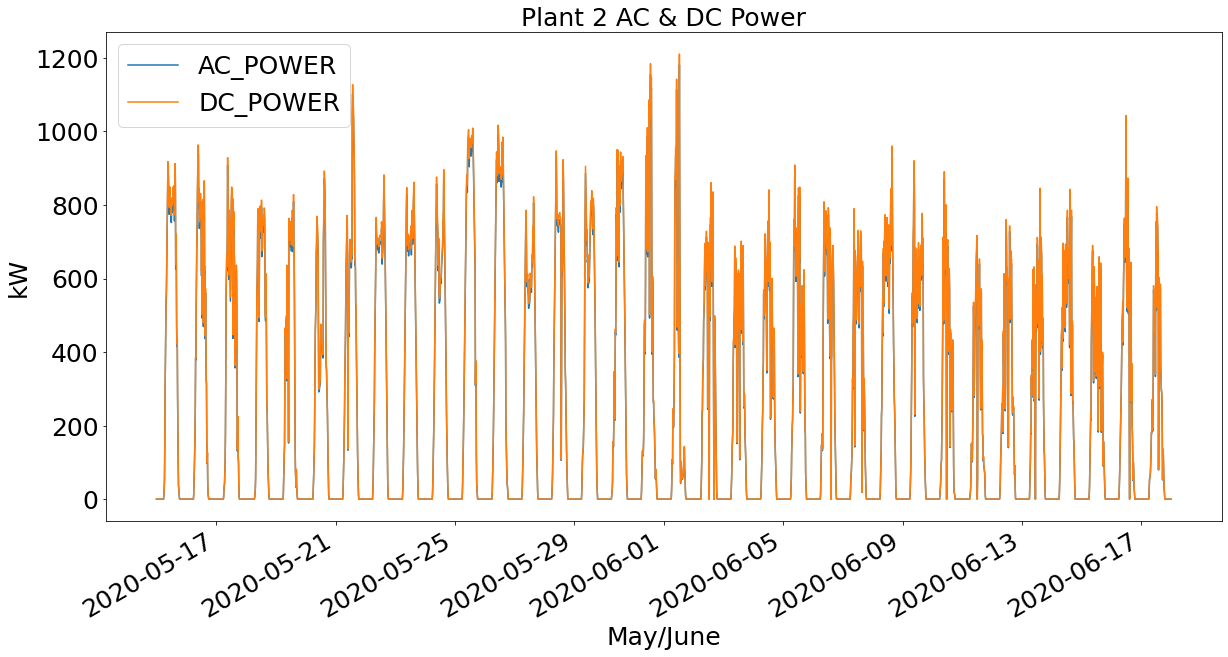

In [36]:
# plot plant 2 AC & DC power
PLANT2_DF1[["AC_POWER","DC_POWER"]].plot(fontsize=25)
fig = plt.gcf()
fig.set_size_inches(20,10)
plt.xlabel("May/June", fontsize=25)
plt.legend(prop={'size': 25})
plt.ylabel("kW", fontsize=25)
plt.title("Plant 2 AC & DC Power", fontsize=25)
plt.savefig("Images\Plant_2_AC_DC")
plt.show()

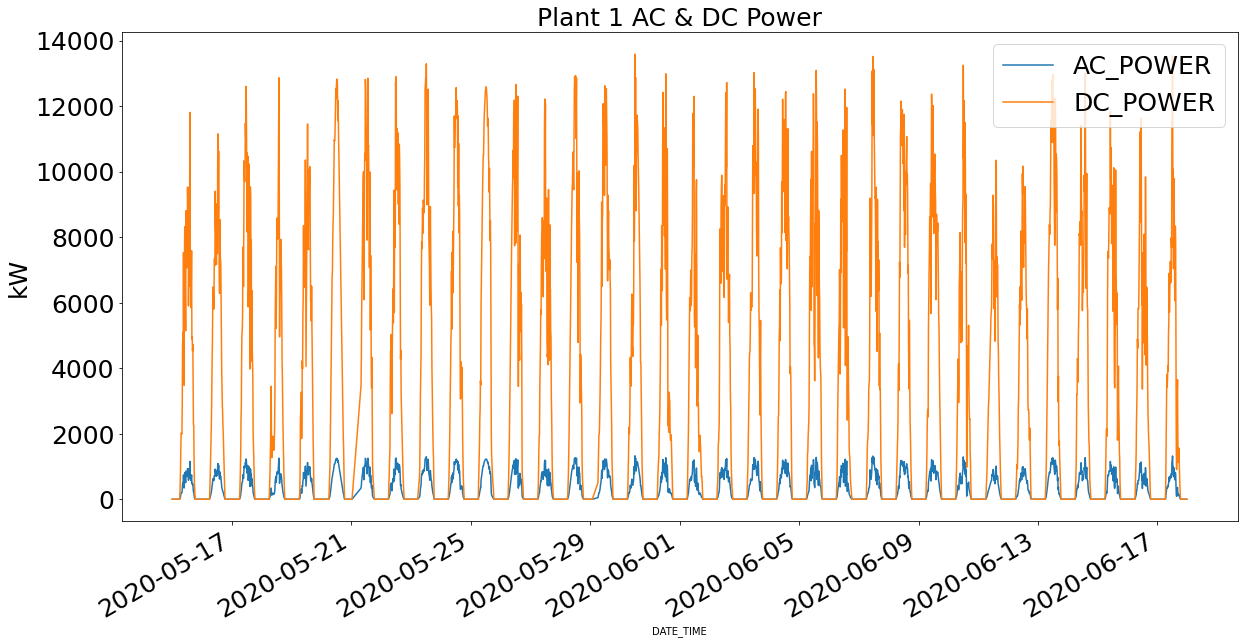

In [37]:
# plot plant 1 AC & DC power
PLANT1_DF1[["AC_POWER","DC_POWER"]].plot(fontsize=25)
fig = plt.gcf()
fig.set_size_inches(20,10)
plt.legend(loc=1,prop={'size': 25})
#plt.xlabel("DateTime")
plt.ylabel("kW", fontsize=25)
plt.title("Plant 1 AC & DC Power", fontsize=25)
plt.savefig("Images\Plant_1_AC_DC")
plt.show()

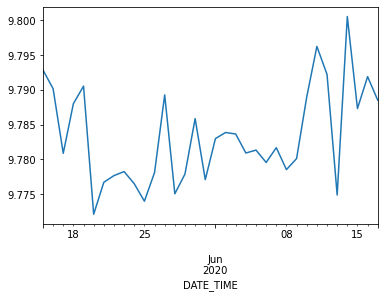

In [38]:
# plot of a source key
PLANT1_DF2_fil = PLANT1_DF2[PLANT1_DF2.SOURCE_KEY == '1BY6WEcLGh8j5v7']
PLANT1_DF2_fil_g = PLANT1_DF2_fil[['DC_POWER','AC_POWER']].groupby(pd.Grouper(freq='D')).mean()
(PLANT1_DF2_fil_g['AC_POWER']/PLANT1_DF2_fil_g['DC_POWER']*100).plot()
plt.show()

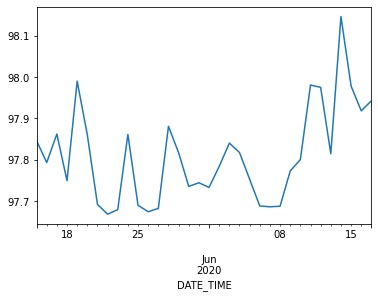

In [39]:
# plot of a source key
PLANT2_DF2_fil = PLANT2_DF2[PLANT2_DF2.SOURCE_KEY == '4UPUqMRk7TRMgml']
PLANT2_DF2_fil_g = PLANT2_DF2_fil[['DC_POWER','AC_POWER']].groupby(pd.Grouper(freq='D')).mean()
(PLANT2_DF2_fil_g['AC_POWER']/PLANT2_DF2_fil_g['DC_POWER']*100).plot()
plt.show()

In [40]:
# create new column in dataframe for the effciency of the inverter
PLANT1_DF2['INVERTER_EFF'] = (PLANT1_DF2['AC_POWER'] / PLANT1_DF2['DC_POWER']) * 100
PLANT2_DF2['INVERTER_EFF'] = (PLANT2_DF2['AC_POWER'] / PLANT2_DF2['DC_POWER']) * 100

In [41]:
# inverter showing an effciency of over 100%
# all values are on the same day at the same time. 
PLANT2_DF2[PLANT2_DF2['INVERTER_EFF'] > 100]

SOURCE_KEY    DC_POWER    AC_POWER  DAILY_YIELD  \
DATE_TIME                                                                   
2020-06-14 08:30:00  4UPUqMRk7TRMgml  516.046667  519.185714   398.285714   
2020-06-14 08:30:00  81aHJ1q11NBPMrL  535.186667  536.907143   671.500000   
2020-06-14 08:30:00  9kRcWv60rDACzjR  565.013333  568.764286   660.142857   
2020-06-14 08:30:00  Et9kgGMDl729KT4  442.480000  442.600000   616.571429   
2020-06-14 08:30:00  IQ2d7wF4YD8zU1Q  522.166667  525.235714   456.714286   
2020-06-14 08:30:00  LYwnQax7tkwH5Cb  544.813333  546.942857   639.785714   
2020-06-14 08:30:00  LlT2YUhhzqhg5Sw  562.786667  566.585714   650.714286   
2020-06-14 08:30:00  Mx2yZCDsyf6DPfv  562.293333  566.971429   690.142857   
2020-06-14 08:30:00  NgDl19wMapZy17u  512.513333  515.471429   623.428571   
2020-06-14 08:30:00  PeE6FRyGXUgsRhN  530.480000  532.728571   623.142857   
2020-06-14 08:30:00  Qf4GUc1pJu5T6c6  479.713333  482.428571   695.571429   
2020-06-14 08:30:00  WcxssY2VbP4hApt  545.240000  547.750000   675.000000   
2020-06-14 08:30:00  mqwcsP2rE7J0TFp  462.746667  464.514286   673.642857   
2020-06-14 08:30:00  oZ35aAeoifZaQzV  533.773333  536.321429   686.928571   
2020-06-14 08:30:00  q49J1IKaHRwDQnt  543.133333  544.135714   661.857143   
2020-06-14 08:30:00  rrq4fwE8jgrTyWY  529.286667  532.164286   641.285714   
2020-06-14 08:30:00  vOuJvMaM2sgwLmb  542.133333  544.071429   673.428571   
2020-06-14 08:30:00  xMbIugepa2P7lBB  548.180000  552.057143   417.142857   

                      TOTAL_YIELD  PLANT_ID  AMBIENT_TEMPERATURE  \
DATE_TIME                                                          
2020-06-14 08:30:00  2.639850e+06   4136001            27.329228   
2020-06-14 08:30:00  1.215463e+09   4136001            27.329228   
2020-06-14 08:30:00  2.247894e+09   4136001            27.329228   
2020-06-14 08:30:00  1.841907e+06   4136001            27.329228   
2020-06-14 08:30:00  2.016208e+07   4136001            27.329228   
2020-06-14 08:30:00  1.795094e+09   4136001            27.329228   
2020-06-14 08:30:00  2.827665e+08   4136001            27.329228   
2020-06-14 08:30:00  2.668127e+06   4136001            27.329228   
2020-06-14 08:30:00  1.117242e+08   4136001            27.329228   
2020-06-14 08:30:00  1.348530e+09   4136001            27.329228   
2020-06-14 08:30:00  8.386334e+08   4136001            27.329228   
2020-06-14 08:30:00  1.818887e+08   4136001            27.329228   
2020-06-14 08:30:00  5.937936e+08   4136001            27.329228   
2020-06-14 08:30:00  1.660173e+09   4136001            27.329228   
2020-06-14 08:30:00  4.984509e+05   4136001            27.329228   
2020-06-14 08:30:00  1.211119e+08   4136001            27.329228   
2020-06-14 08:30:00  2.404771e+06   4136001            27.329228   
2020-06-14 08:30:00  1.068736e+08   4136001            27.329228   

                     MODULE_TEMPERATURE  IRRADIATION  INVERTER_EFF  
DATE_TIME                                                           
2020-06-14 08:30:00           34.377896     0.406732    100.608288  
2020-06-14 08:30:00           34.377896     0.406732    100.321472  
2020-06-14 08:30:00           34.377896     0.406732    100.663870  
2020-06-14 08:30:00           34.377896     0.406732    100.027120  
2020-06-14 08:30:00           34.377896     0.406732    100.587752  
2020-06-14 08:30:00           34.377896     0.406732    100.390872  
2020-06-14 08:30:00           34.377896     0.406732    100.675042  
2020-06-14 08:30:00           34.377896     0.406732    100.831967  
2020-06-14 08:30:00           34.377896     0.406732    100.577174  
2020-06-14 08:30:00           34.377896     0.406732    100.423875  
2020-06-14 08:30:00           34.377896     0.406732    100.566013  
2020-06-14 08:30:00           34.377896     0.406732    100.460348  
2020-06-14 08:30:00           34.377896     0.406732    100.381984  
2020-06-14 08:30:00           34.377896     0.406732    100.477374  
2020-06-14 08:30:00 

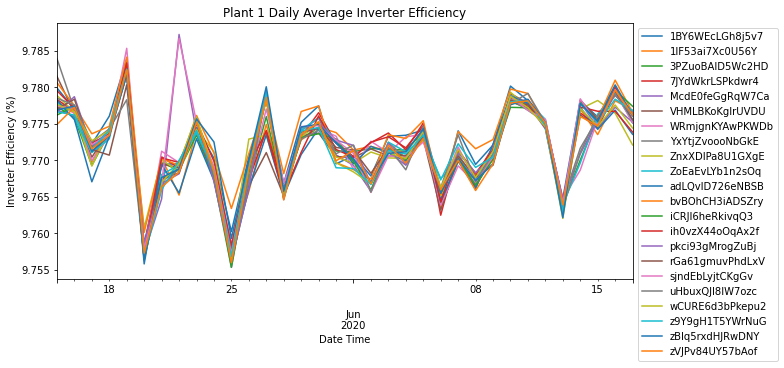

In [42]:
#PLANT 1 effciency by source key
PLANT1_DF2_agg = PLANT1_DF2.groupby([pd.Grouper(freq='D'),'SOURCE_KEY']).mean()
PLANT1_DF2_aggie = PLANT1_DF2_agg.unstack(level=1)['INVERTER_EFF']

PLANT1_DF2_aggie.plot(figsize=(11,5),legend=True)

plt.title('Plant 1 Daily Average Inverter Efficiency')
plt.xlabel('Date Time')
plt.ylabel('Inverter Efficiency (%)')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()
plt.savefig("Images\Plant 1 Daily Average Inverter Efficiency")
plt.show()


It seems Plant 1 is showing problems with the effciency of its inverter. It would be best for the operational managers at the solar plant to investivate this further. 

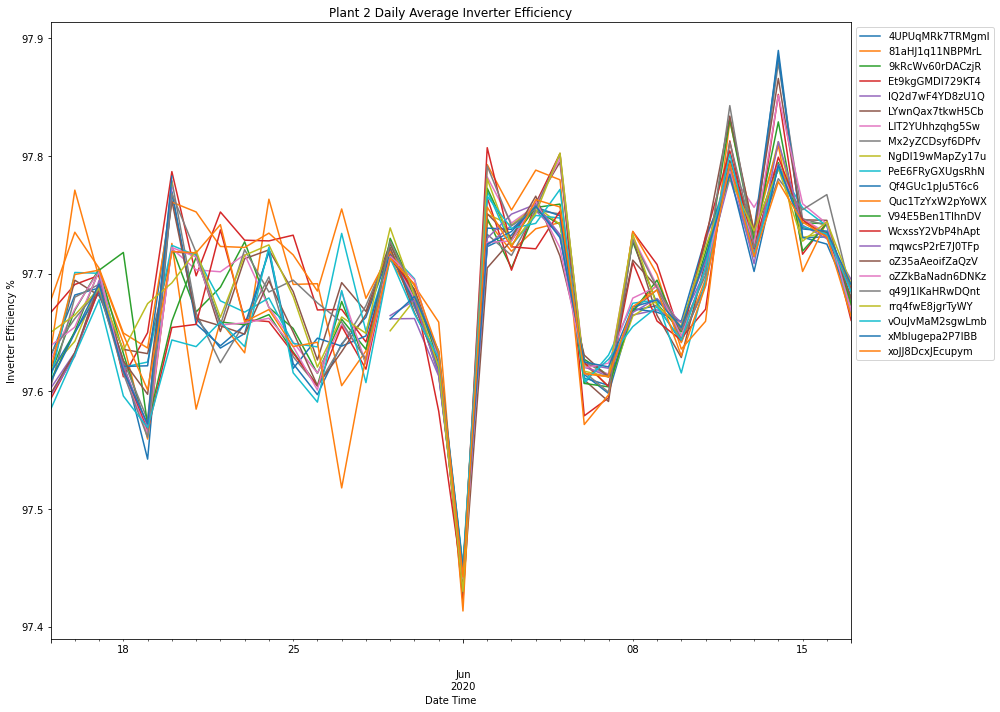

In [43]:
#PLANT 2 effciency by source key
PLANT2_DF2_agg = PLANT2_DF2.groupby([pd.Grouper(freq='D'),'SOURCE_KEY']).mean()
PLANT2_DF2_aggie = PLANT2_DF2_agg.unstack(level=1)['INVERTER_EFF']

PLANT2_DF2_aggie.plot(figsize=(14,10),legend=True)

plt.title('Plant 2 Daily Average Inverter Efficiency')
plt.xlabel('Date Time')
plt.ylabel('Inverter Efficiency %')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()
plt.savefig("Images\Plant 2 Daily Average Inverter Efficiency")
plt.show()

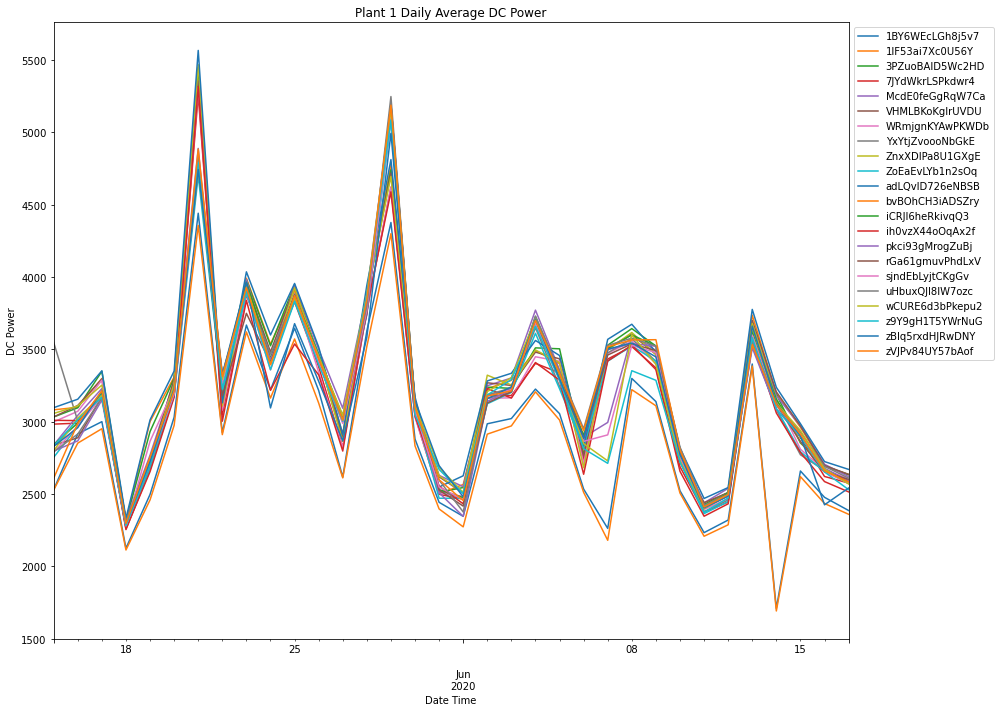

In [44]:
#PLANT 1 average DC power produced 
PLANT1_DF2_aggdc = PLANT1_DF2_agg.unstack(level=1)['DC_POWER']
PLANT1_DF2_aggdc.plot(figsize=(14,10),legend=True)

plt.title('Plant 1 Daily Average DC Power')
plt.xlabel('Date Time')
plt.ylabel('DC Power')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()
plt.savefig("Images\Plant 1 Daily Average DC Power")
plt.show()

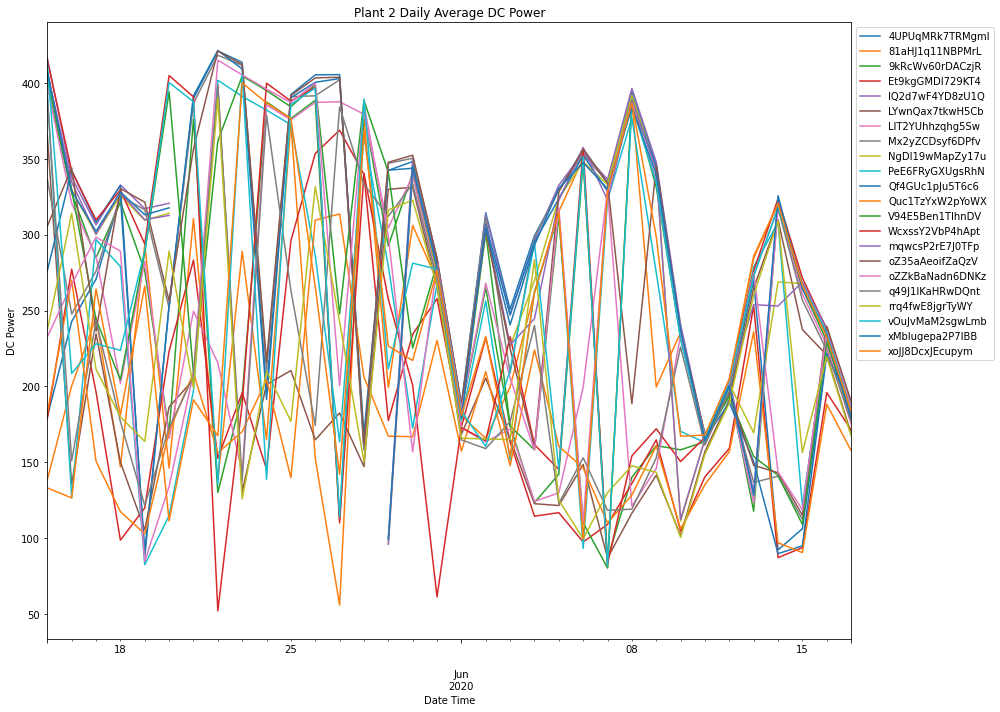

In [45]:
#PLANT 2 average DC power produced
PLANT2_DF2_aggdc = PLANT2_DF2_agg.unstack(level=1)['DC_POWER']
PLANT2_DF2_aggdc.plot(figsize=(14,10),legend=True)

plt.title('Plant 2 Daily Average DC Power')
plt.xlabel('Date Time')
plt.ylabel('DC Power')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()
plt.show()

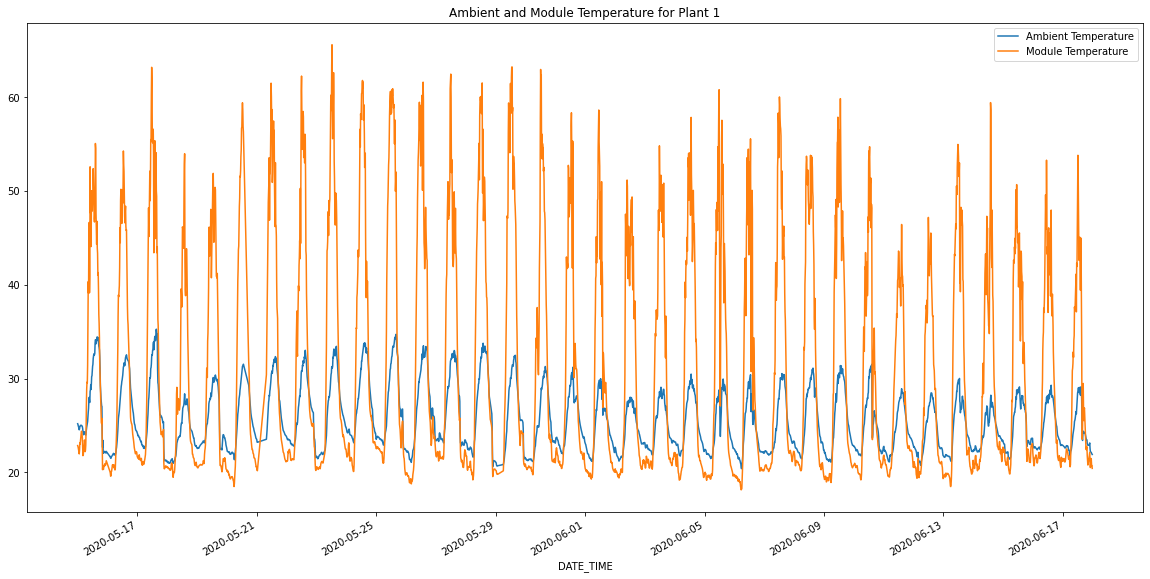

In [46]:
# plot of ambient temperature of plant 1
ax = PLANT1_DF1['AMBIENT_TEMPERATURE'].plot(label='Ambient Temperature')
PLANT1_DF1['MODULE_TEMPERATURE'].plot(ax=ax, label='Module Temperature')
fig = plt.gcf()
fig.set_size_inches(20,10)
plt.legend()
plt.title("Ambient and Module Temperature for Plant 1")
plt.savefig(r"Images\Ambient Module Temperature Plant 1")
plt.show()

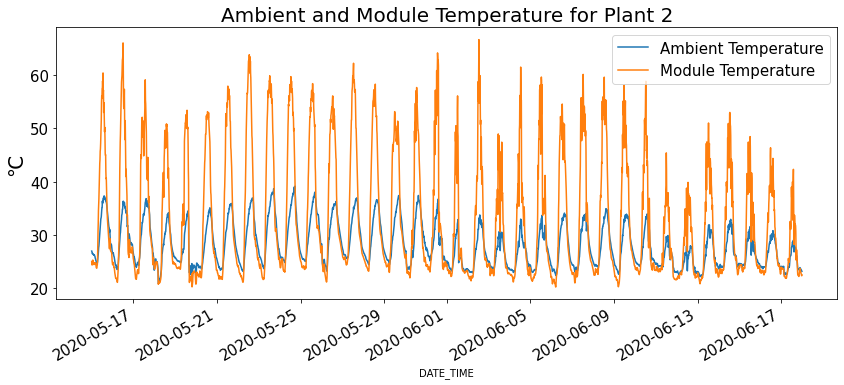

In [47]:
# plot of ambient temperature of plant 2
ax = PLANT2_DF1['AMBIENT_TEMPERATURE'].plot(label='Ambient Temperature', fontsize=15)
PLANT2_DF1['MODULE_TEMPERATURE'].plot(ax=ax, label='Module Temperature',fontsize=15)
fig = plt.gcf()
fig.set_size_inches(14,6)
plt.legend(loc=1,prop={'size': 15})
plt.title("Ambient and Module Temperature for Plant 2",fontsize=20)
#plt.xlabel("DateTime")
plt.ylabel("℃", fontsize=20)
plt.subplots_adjust(bottom=0.25)
plt.savefig(r"Images\Ambient Module Temperature Plant 2")
plt.show()

In [48]:
# filter plant 1 with DC power over 0
PLANT1_DF2_DC_MT = PLANT1_DF2[['DC_POWER', 'MODULE_TEMPERATURE']]
PLANT1_DF2_DC_MT = PLANT1_DF2_DC_MT[PLANT1_DF2_DC_MT.DC_POWER > 0]
PLANT1_DF2_DC_MT.head()

DC_POWER  MODULE_TEMPERATURE
DATE_TIME                                           
2020-05-15 06:00:00    37.142857           22.206757
2020-05-15 06:15:00   278.000000           22.353459
2020-05-15 06:30:00   626.571429           22.893282
2020-05-15 06:45:00  1224.750000           24.442444
2020-05-15 07:00:00  1734.571429           27.185653

In [49]:
# create new feature in plant 2 for number of source keys grouped by date time
PLANT2_DF2['num_of_SK'] = PLANT2_DF2.groupby(['DATE_TIME']).size()
print(len(PLANT2_DF2))
print(PLANT2_DF2['num_of_SK'].unique())

67698
[22 18 12]


In [50]:
# filter plant 2 based on: module temperature being higher than ambient temperature, num of soure keys over 20 and DC power over 0
PLANT2_DF2_DC_MT = PLANT2_DF2[['DC_POWER', 'MODULE_TEMPERATURE', 'AMBIENT_TEMPERATURE','num_of_SK']]
PLANT2_DF2_DC_MT = PLANT2_DF2_DC_MT[PLANT2_DF2_DC_MT['MODULE_TEMPERATURE'] > PLANT2_DF2_DC_MT['AMBIENT_TEMPERATURE']] 
PLANT2_DF2_DC_MT = PLANT2_DF2_DC_MT[PLANT2_DF2_DC_MT['DC_POWER'] > 0]
PLANT2_DF2_DC_MT = PLANT2_DF2_DC_MT[PLANT2_DF2_DC_MT['num_of_SK'] > 20]
PLANT2_DF2_DC_MT = PLANT2_DF2_DC_MT[['DC_POWER','MODULE_TEMPERATURE']]

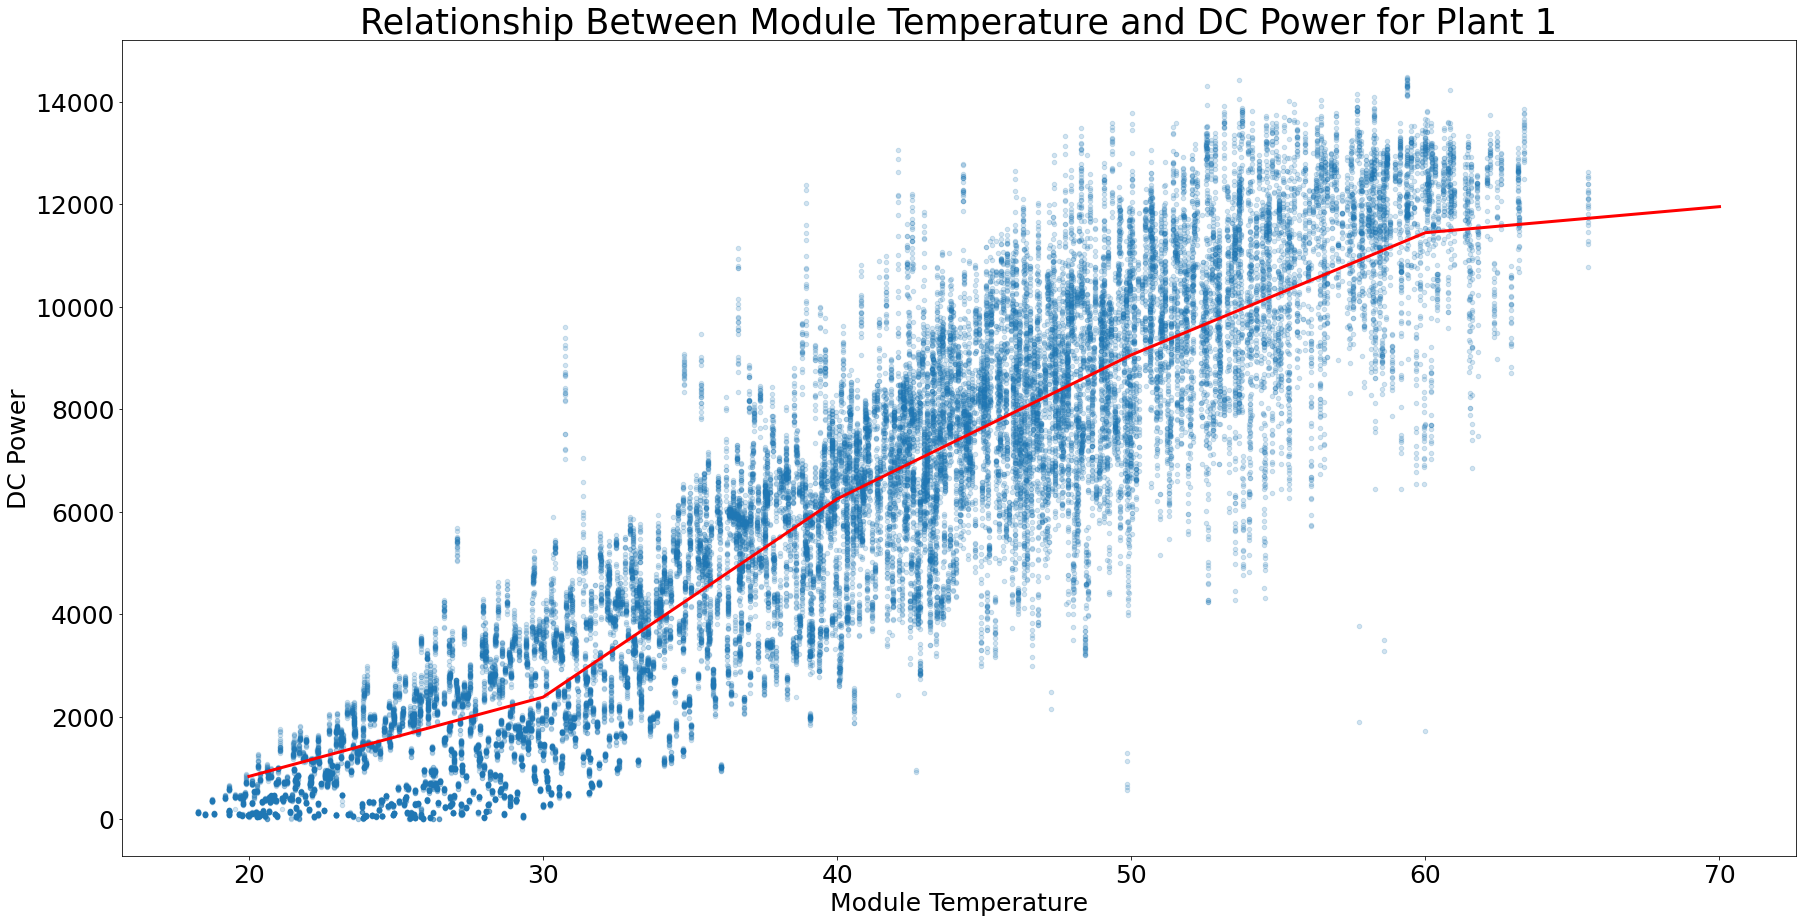

In [51]:
# plot temp by power to find max effciency in plant 1
PLANT1_DF2_DC_MT_R = PLANT1_DF2_DC_MT.copy()
PLANT1_DF2_DC_MT_R['MODULE_TEMPERATURE'] = PLANT1_DF2_DC_MT_R['MODULE_TEMPERATURE'].round(-1)
PLANT1_DF2_DC_MT_R = PLANT1_DF2_DC_MT_R.groupby('MODULE_TEMPERATURE').mean().reset_index() # Use mean as we want it to be sensitive to outliers

ax = PLANT1_DF2_DC_MT.plot(kind='scatter', x='MODULE_TEMPERATURE', y='DC_POWER', 
                           figsize=(30,15), alpha=0.2, fontsize=25)     

X = PLANT1_DF2_DC_MT_R.MODULE_TEMPERATURE
y = PLANT1_DF2_DC_MT_R.DC_POWER

plt.plot(X, y, 'r', linewidth=3)

plt.title('Relationship Between Module Temperature and DC Power for Plant 1', fontsize=35)
plt.ylabel('DC Power', fontsize=25)
plt.xlabel('Module Temperature', fontsize=25)
plt.savefig("Images\Module Temperature and DC Power for Plant 1")
plt.show()

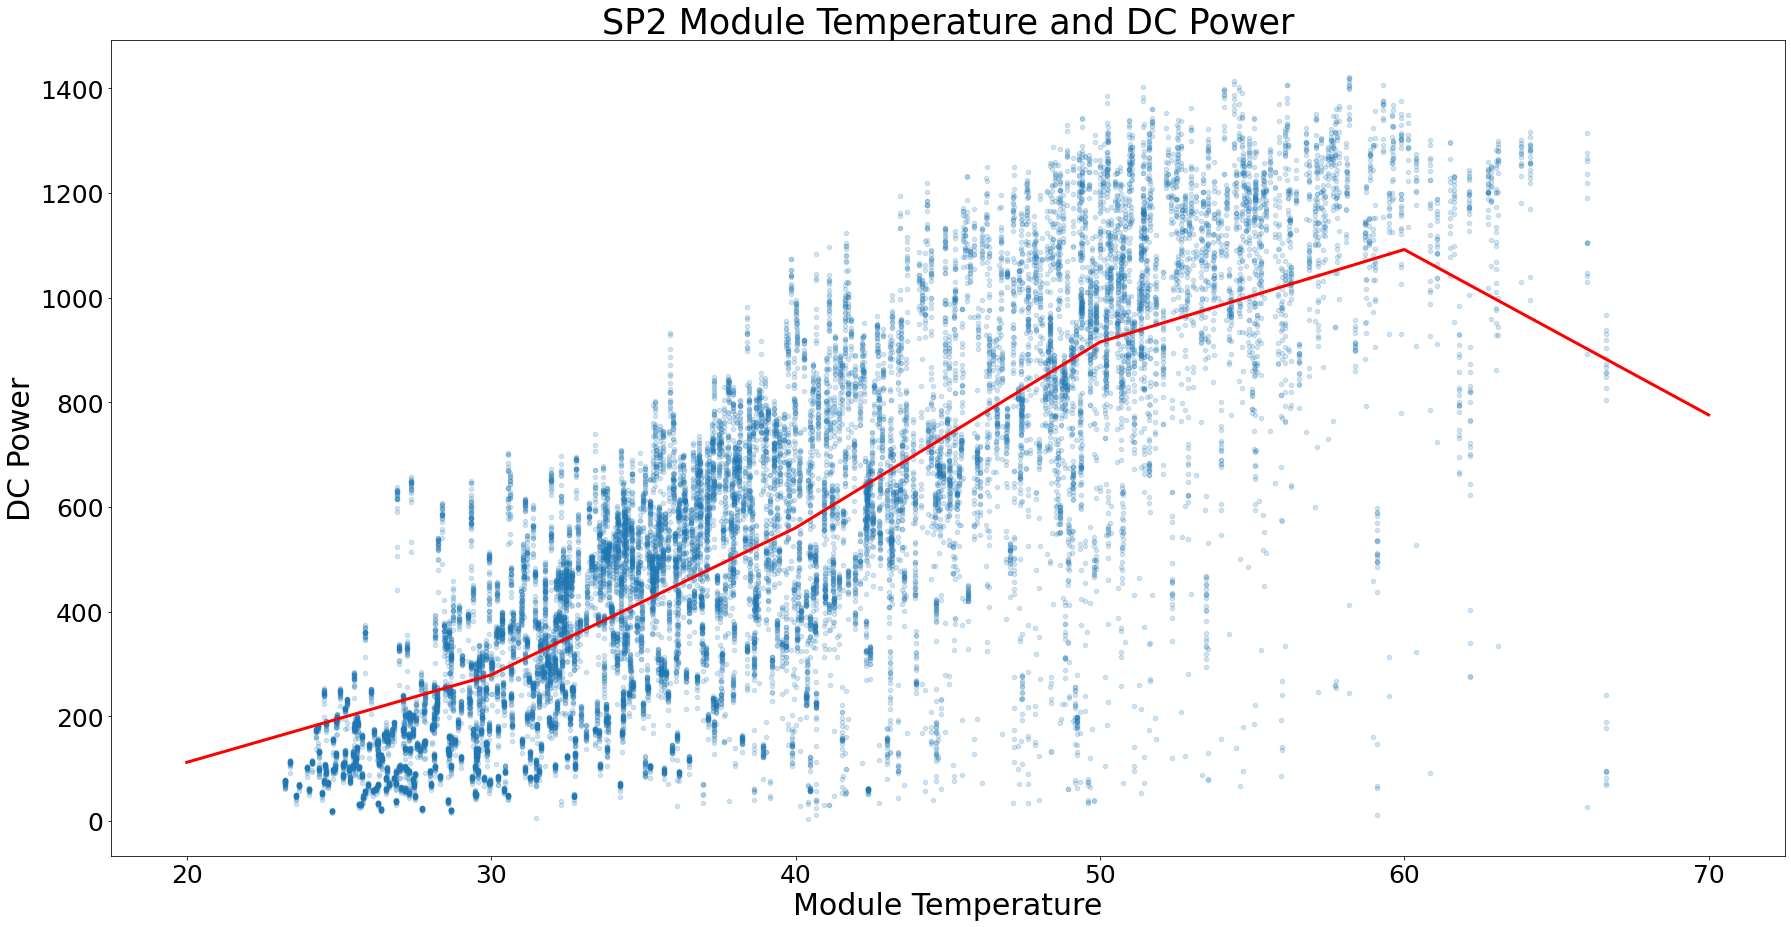

In [52]:
# plot temp by power to find max effciency for plant 2
PLANT2_DF2_DC_MT_R = PLANT2_DF2_DC_MT.copy()
PLANT2_DF2_DC_MT_R['MODULE_TEMPERATURE'] = PLANT2_DF2_DC_MT_R['MODULE_TEMPERATURE'].round(-1)
PLANT2_DF2_DC_MT_R = PLANT2_DF2_DC_MT_R.groupby('MODULE_TEMPERATURE').mean().reset_index() # Use mean as we want it to be sensitive to outliers

ax = PLANT2_DF2_DC_MT.plot(kind='scatter', x='MODULE_TEMPERATURE', y='DC_POWER', 
                           figsize=(30,15), alpha=0.2, fontsize=25)     

X = PLANT2_DF2_DC_MT_R.MODULE_TEMPERATURE
y = PLANT2_DF2_DC_MT_R.DC_POWER

plt.plot(X, y, 'r', linewidth=3)

plt.title('SP2 Module Temperature and DC Power', fontsize=35)
plt.ylabel('DC Power', fontsize=30)
plt.xlabel('Module Temperature', fontsize=30)
plt.savefig("Images\Module Temperature and DC Power for Plant 2")
plt.show()

In [53]:
# filter plant 2/1 on values above 0 as it shows no light and below 50 degrees as the module is inefficient. 
PLANT1_DF2_DC = PLANT1_DF2[['SOURCE_KEY', 'DC_POWER', 'MODULE_TEMPERATURE']]
PLANT1_DF2_DC = PLANT1_DF2_DC[(PLANT1_DF2_DC['DC_POWER'] > 0) & (PLANT1_DF2_DC['MODULE_TEMPERATURE'] < 50)]  
PLANT1_DF2_DC = PLANT1_DF2_DC.pivot(columns='SOURCE_KEY', values='DC_POWER')

PLANT2_DF2_DC = PLANT2_DF2[['SOURCE_KEY', 'DC_POWER', 'MODULE_TEMPERATURE']]
PLANT2_DF2_DC = PLANT2_DF2_DC[(PLANT2_DF2_DC['DC_POWER'] > 0) & (PLANT2_DF2_DC['MODULE_TEMPERATURE'] < 50)]  
PLANT2_DF2_DC = PLANT2_DF2_DC.pivot(columns='SOURCE_KEY', values='DC_POWER')

In [54]:
# convert plant 1/2 datetime index into a specific format used to create a graph 
PLANT1_DF2_DC_ri = PLANT1_DF2_DC.reset_index()
PLANT1_DF2_DC_ri['DATE_TIME'] = pd.Series([val.time() for val in PLANT1_DF2_DC_ri['DATE_TIME']])
PLANT1_DF2_DC_ri['DATE_TIME'] = [val.strftime("%H%M") for val in PLANT1_DF2_DC_ri['DATE_TIME']]

PLANT2_DF2_DC_ri = PLANT2_DF2_DC.reset_index()
PLANT2_DF2_DC_ri['DATE_TIME'] = pd.Series([val.time() for val in PLANT2_DF2_DC_ri['DATE_TIME']])
PLANT2_DF2_DC_ri['DATE_TIME'] = [val.strftime("%H%M") for val in PLANT2_DF2_DC_ri['DATE_TIME']]

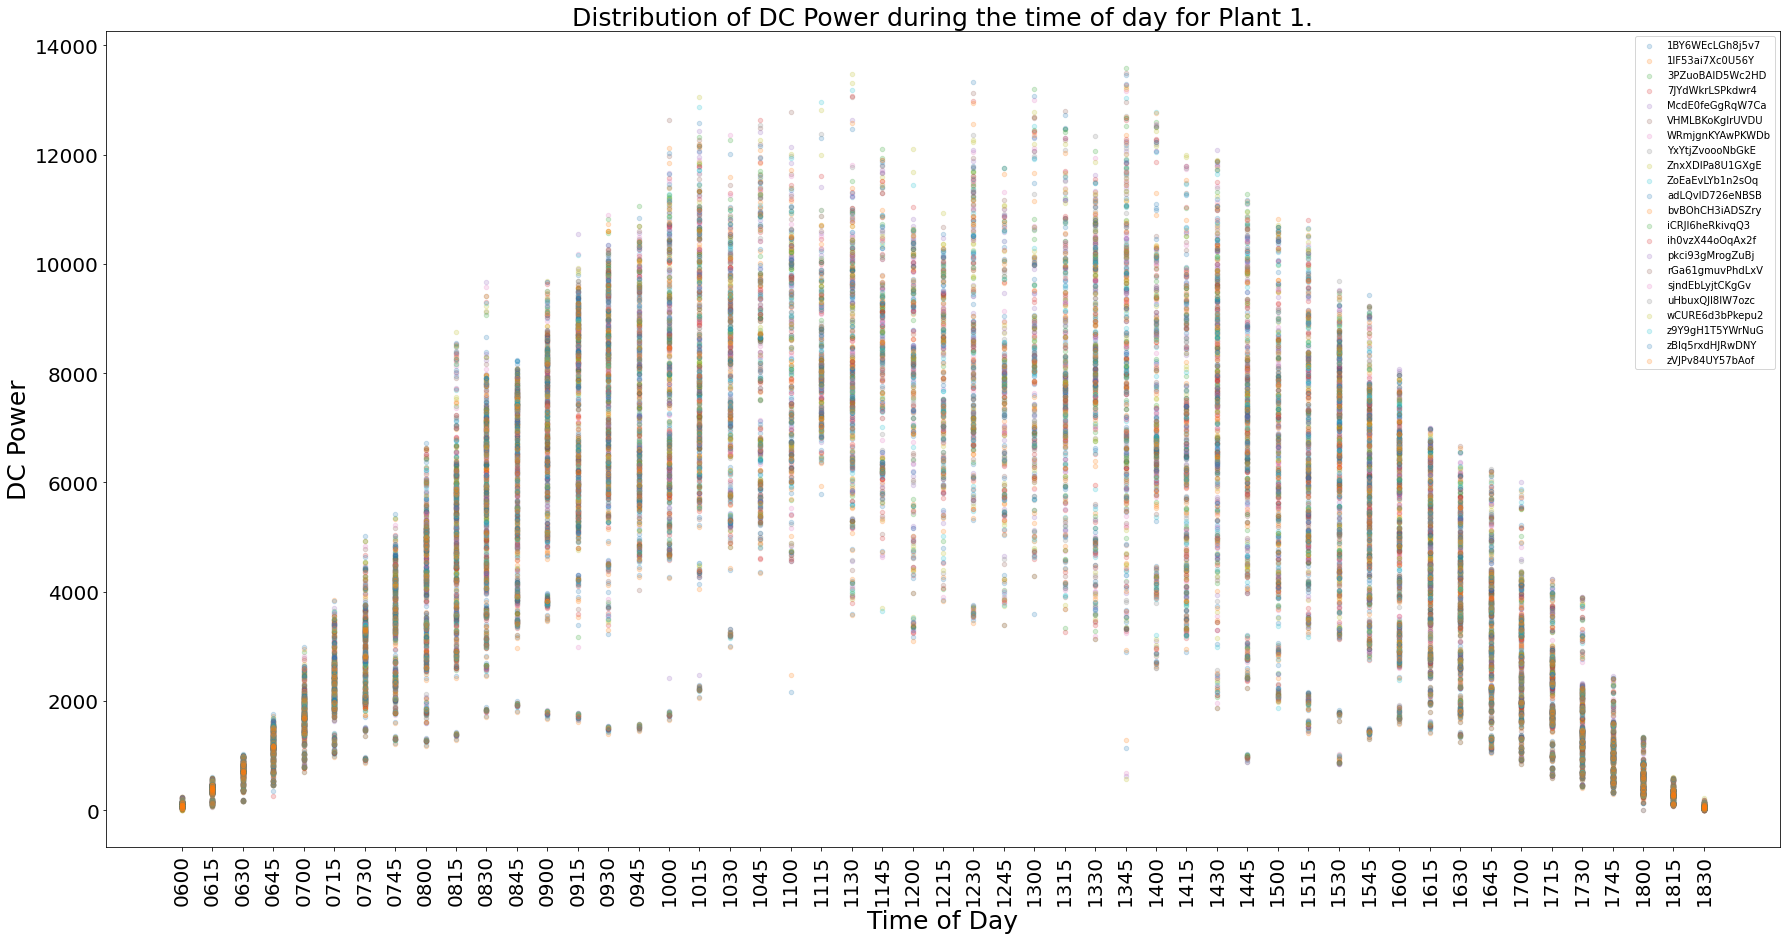

In [55]:
# distribution of plant 1 DC power over the course of 24 hours.
palette = sns.color_palette(None, 22)

PLANT1_DF2_DC_ri = PLANT1_DF2_DC_ri.sort_values('DATE_TIME', axis=0, ascending=True)
ax = PLANT1_DF2_DC_ri.plot(kind='scatter', x='DATE_TIME', y=PLANT1_DF2_DC_ri.columns[1], color=palette[0], 
                           label=PLANT1_DF2_DC_ri.columns[1], figsize=(30,15), alpha=0.2, fontsize=20)           

for col, c in zip(PLANT1_DF2_DC_ri.columns[2:], palette[1:]):
    PLANT1_DF2_DC_ri.plot(kind='scatter', x='DATE_TIME', y=col, color=c, label=col ,ax=ax, alpha=0.2, fontsize=20)


plt.legend()
plt.title('Distribution of DC Power during the time of day for Plant 1.',fontsize=25)
plt.xlabel('Time of Day', fontsize=25)
plt.xticks(rotation=90)
plt.ylabel('DC Power',fontsize=25)
plt.savefig("Images\Daily Distribution DC Power Plant 1")
plt.show()

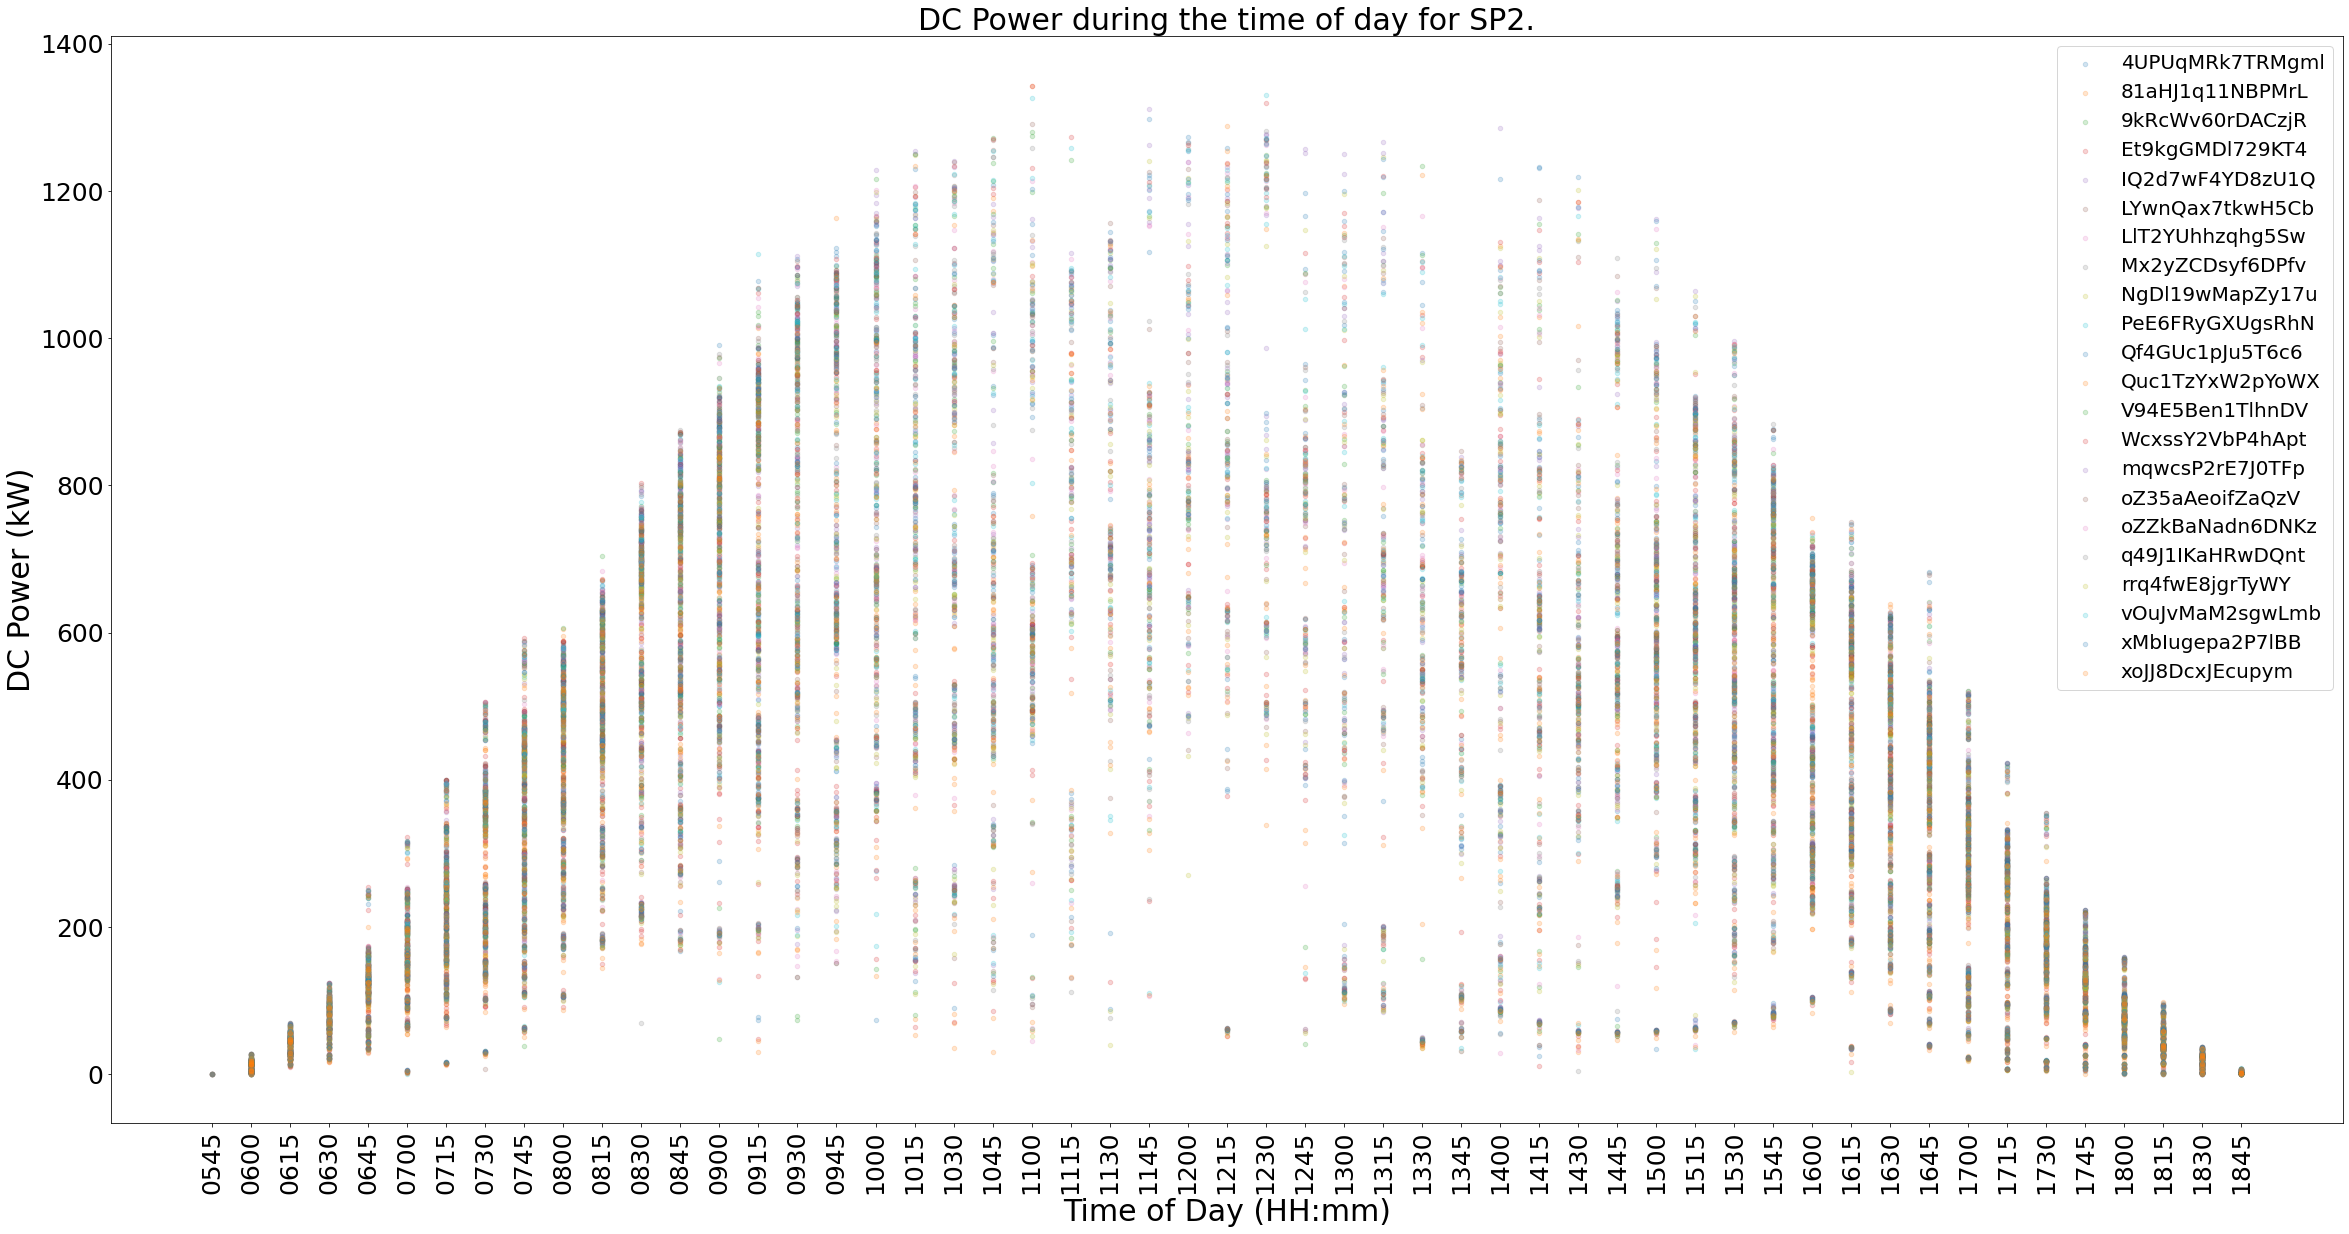

In [56]:
# distribution of plant 2 DC power over the course of 24 hours.
palette2 = sns.color_palette(None, 22)

PLANT2_DF2_DC_ri = PLANT2_DF2_DC_ri.sort_values('DATE_TIME', axis=0, ascending=True)
ax = PLANT2_DF2_DC_ri.plot(kind='scatter', x='DATE_TIME', y=PLANT2_DF2_DC_ri.columns[1], color=palette2[0], 
                           label=PLANT2_DF2_DC_ri.columns[1], figsize=(40,20), alpha=0.2, fontsize=20)           

for col, c in zip(PLANT2_DF2_DC_ri.columns[2:], palette2[1:]):
    PLANT2_DF2_DC_ri.plot(kind='scatter', x='DATE_TIME', y=col, color=c, label=col,
                          ax=ax, alpha=0.2, fontsize=25)


plt.legend(fontsize=15)
plt.title('DC Power during the time of day for SP2.',fontsize=30)
plt.xlabel('Time of Day (HH:mm)', fontsize=30)
plt.legend(loc=1,prop={'size': 20})
plt.xticks(rotation=90)
plt.ylabel('DC Power (kW)',fontsize=30)
plt.savefig("Images\Daily Distribution DC Power Plant 2")
plt.show()

Lastly, use this dataframe to find source keys that are outliers compared to other source keys at that same time. This will help identify sub-optimally performing modules.

In [57]:
# for each row find the mean value and check if any outliers are below the mean to avoid over performing panels.
# a count was performed to see if there were multiple source keys that were ouliers in that row. this returned 0.
low_performance = []

for i in range(len(PLANT1_DF2_DC)):
    
    q_low = PLANT1_DF2_DC.iloc[i].quantile(0.001)
    if any(PLANT1_DF2_DC.iloc[i] < q_low):
        source_key = PLANT1_DF2_DC.iloc[i][PLANT1_DF2_DC.iloc[i] < q_low].index[0]
        time_stamp = PLANT1_DF2_DC.index[i]
        
        dc_power = PLANT1_DF2_DC.iloc[i][PLANT1_DF2_DC.iloc[i] < q_low][0]
        mean_dc = PLANT1_DF2_DC.iloc[i].quantile(0.5)
        low_performance.append([time_stamp, source_key, dc_power, mean_dc])        
    

In [58]:
low_performance2 = []

for i in range(len(PLANT2_DF2_DC)):
    
    q_low = PLANT2_DF2_DC.iloc[i].quantile(0.001)
    if any(PLANT2_DF2_DC.iloc[i] < q_low):
        source_key = PLANT2_DF2_DC.iloc[i][PLANT2_DF2_DC.iloc[i] < q_low].index.to_list()
        time_stamp = PLANT2_DF2_DC.index[i]
        
        dc_power = PLANT2_DF2_DC.iloc[i][PLANT2_DF2_DC.iloc[i] < q_low][0]
        mean_dc = PLANT2_DF2_DC.iloc[i].quantile(0.5)
        low_performance2.append([time_stamp, source_key, dc_power, mean_dc])        

In [59]:
# dataframe of low performing modules for plant 1 and their time, DC power and mean power.
columns = ['Date Time', 'Source Key', 'DC Power', 'Mean Power']
low_per_df = pd.DataFrame(low_performance, columns=columns).set_index('Date Time')
low_per_df.head()

Source Key     DC Power   Mean Power
Date Time                                                     
2020-05-15 06:00:00  ZoEaEvLYb1n2sOq    24.500000    51.395833
2020-05-15 06:15:00  VHMLBKoKgIrUVDU    61.125000   307.142857
2020-05-15 06:30:00  zVJPv84UY57bAof   614.875000   690.812500
2020-05-15 06:45:00  zVJPv84UY57bAof  1166.857143  1297.785714
2020-05-15 07:00:00  zVJPv84UY57bAof  1661.500000  1879.537500

In [60]:
# dataframe of low performing modules for plant 2 and their time, DC power and mean power.
columns = ['Date Time', 'Source Key', 'DC Power', 'Mean Power']
low_per_df2 = pd.DataFrame(low_performance2, columns=columns).set_index('Date Time')
low_per_df2.head()

Source Key    DC Power  Mean Power
Date Time                                                     
2020-05-15 06:00:00  [Quc1TzYxW2pYoWX]   11.420000   15.170000
2020-05-15 06:15:00  [Quc1TzYxW2pYoWX]   21.007143   27.010000
2020-05-15 06:30:00  [Quc1TzYxW2pYoWX]   44.553333   59.133810
2020-05-15 06:45:00  [Quc1TzYxW2pYoWX]  121.826667  160.513571
2020-05-15 07:00:00  [Quc1TzYxW2pYoWX]  246.706667  311.953333

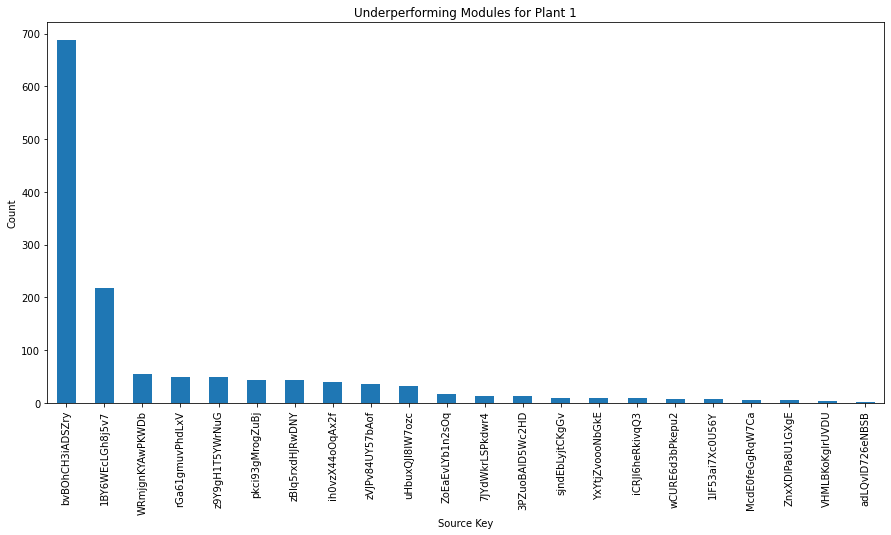

In [366]:
# count of low performing modules for plant 1
low_per_df['Source Key'].value_counts().plot(kind='bar', figsize=(15,7))

plt.title('Underperforming Modules for Plant 1')
plt.xlabel('Source Key')
plt.ylabel('Count')
plt.savefig(r"Images\Underperforming in Plant 1")
plt.show()

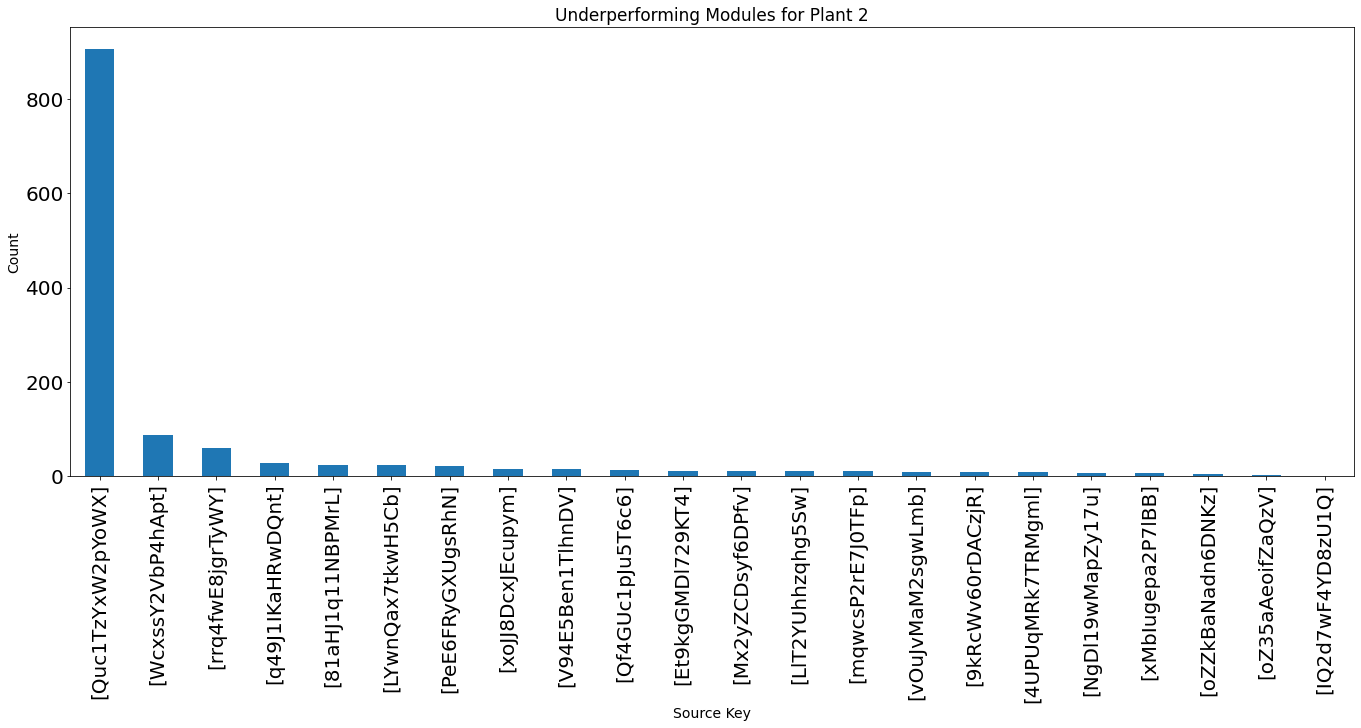

In [62]:
# count of low performing modules for plant 2
low_per_df2['Source Key'].value_counts().plot(kind='bar', figsize=(23,13), fontsize=20)

plt.title('Underperforming Modules for Plant 2', fontsize=17)
plt.xlabel('Source Key', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.subplots_adjust(bottom=0.40)
plt.savefig(r"Images\Underperforming in Plant 2")
plt.show()

In [63]:
def source_key_eff_plot(df, sk, plt_no):
    """
    Plots the number of time a source key was underperforming for time of day.
    """
    worst_per = df[df['Source Key'] == sk]
    worst_per = worst_per.groupby([pd.Grouper(freq='D')]).sum()
    worst_per['percent_loss'] = ((worst_per['Mean Power'] - worst_per['DC Power']) / worst_per['Mean Power']) * 100
    
    worst_per['percent_loss'].plot(use_index=True, kind='bar',figsize=(15,8))
    
    plt.xticks(rotation=90)
    plt.title(f'Percentage loss for Source Key {sk} in Plant {plt_no}')
    plt.ylabel('% loss')
    #plt.savefig(r"Images\Percentage loss source key")
    plt.xlabel('Date Time')
    plt.show()

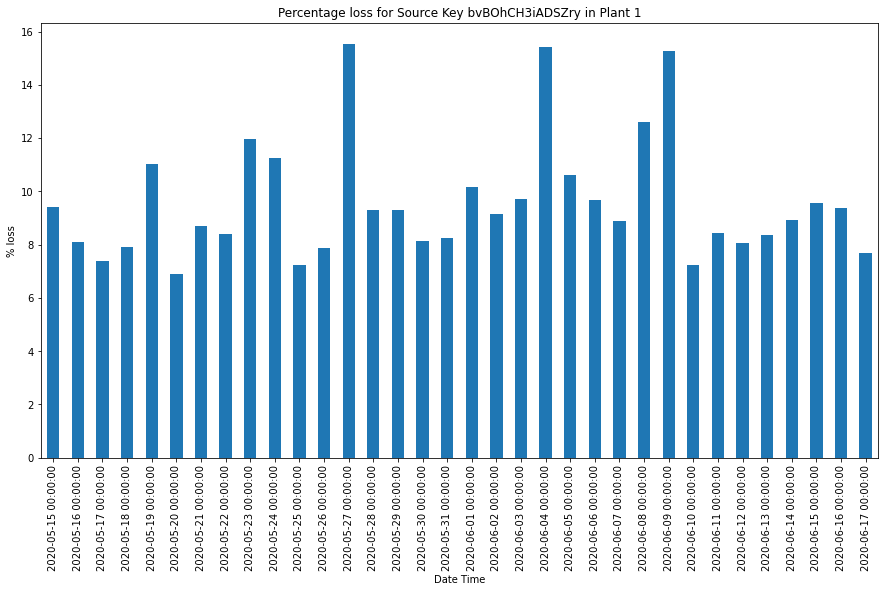

In [64]:
source_key_eff_plot(low_per_df, low_per_df['Source Key'].value_counts().index[0],1)


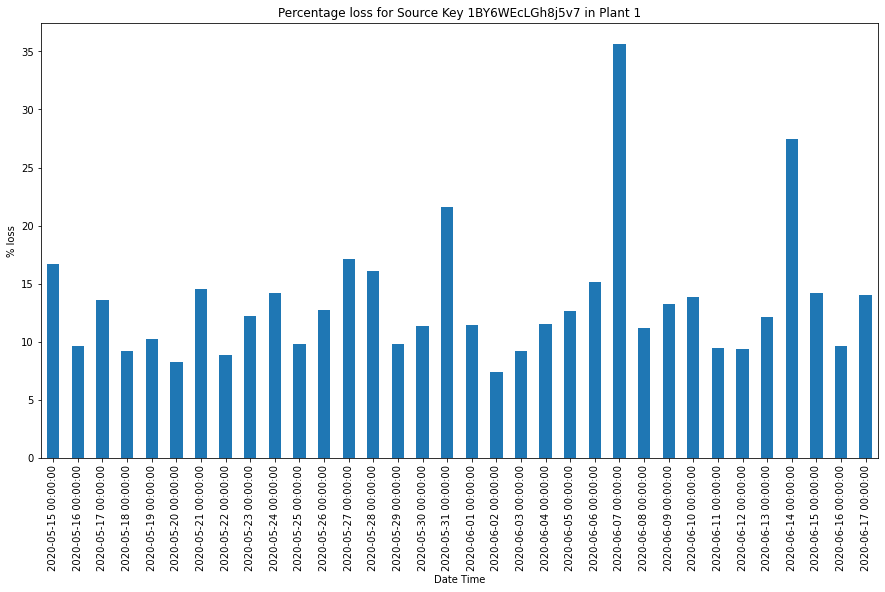

In [65]:
source_key_eff_plot(low_per_df,low_per_df['Source Key'].value_counts().index[1],1)

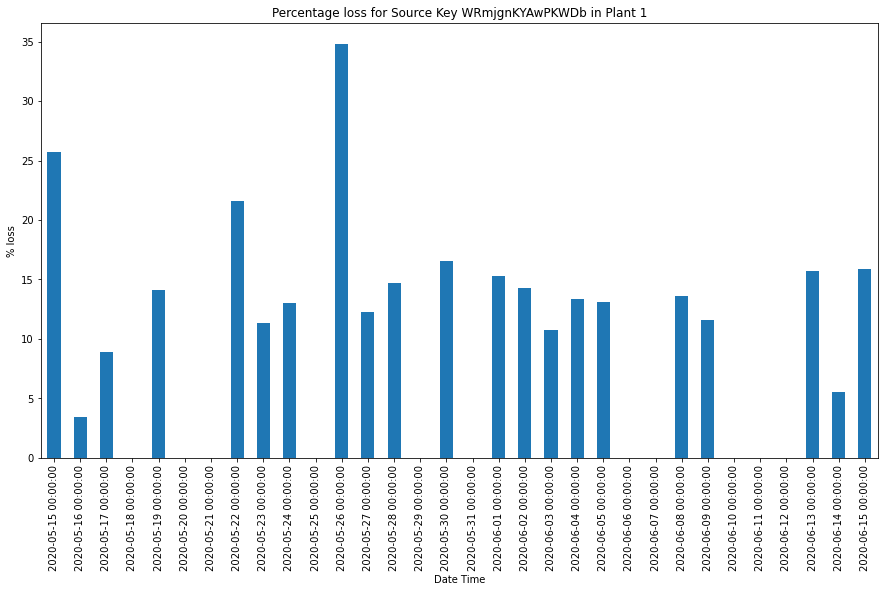

In [66]:
source_key_eff_plot(low_per_df,low_per_df['Source Key'].value_counts().index[2],1)

# Machine Learning / Deep Learning

Now we will try to predict the power output of DC power over 2 days for plant 2 using SARIMA, XGBOOST and CNN-LSTM. As we want to avoid extreme predictions, mean squared error will be our metric to compare the different models.

In [67]:
# drop plant id from plant2
PLANT2_DF1.drop('PLANT_ID', axis=1, inplace=True)

In [68]:
PLANT2_DF1 = PLANT2_DF1.groupby(pd.Grouper(freq='H')).agg({'AMBIENT_TEMPERATURE':'mean',
                                                      'MODULE_TEMPERATURE':'mean',
                                                      'IRRADIATION':'mean',
                                                      'DC_POWER':'mean',
                                                      'AC_POWER':'mean',
                                                      'DAILY_YIELD':'sum',
                                                      'TOTAL_YIELD':'sum',
                                                      'num_of_SK': 'mean'})
PLANT2_DF1.head()

AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  \
DATE_TIME                                                                   
2020-05-15 00:00:00            26.767055           24.582656          0.0   
2020-05-15 01:00:00            26.505909           25.172109          0.0   
2020-05-15 02:00:00            26.296562           24.555514          0.0   
2020-05-15 03:00:00            26.141691           24.627655          0.0   
2020-05-15 04:00:00            25.509473           24.658230          0.0   

                     DC_POWER  AC_POWER    DAILY_YIELD   TOTAL_YIELD  \
DATE_TIME                                                              
2020-05-15 00:00:00       0.0       0.0  134102.938095  5.675838e+10   
2020-05-15 01:00:00       0.0       0.0   83444.000000  5.675838e+10   
2020-05-15 02:00:00       0.0       0.0   75904.000000  5.675838e+10   
2020-05-15 03:00:00       0.0       0.0   75537.666667  5.675838e+10   
2020-05-15 04:00:00       0.0       0.0   53924.000000  5.675838e+10   

                     num_of_SK  
DATE_TIME                       
2020-05-15 00:00:00       22.0  
2020-05-15 01:00:00       22.0  
2020-05-15 02:00:00       22.0  
2020-05-15 03:00:00       22.0  
2020-05-15 04:00:00       22.0

In [69]:
# PLANT1_DF1 = PLANT1_DF1.groupby(pd.Grouper(freq='H')).agg({'AMBIENT_TEMPERATURE':'mean',
#                                                       'MODULE_TEMPERATURE':'mean',
#                                                       'IRRADIATION':'mean',
#                                                       'DC_POWER':'mean',
#                                                       'AC_POWER':'mean',
#                                                       'DAILY_YIELD':'sum',
#                                                       'TOTAL_YIELD':'sum',
#                                                       'num_of_SK': 'mean'})
# PLANT1_DF1.head()

In [70]:
# PLANT1_DF1.isna().sum()

In [71]:
# PLANT1_DF1[['AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION']] = PLANT1_DF1[['AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION']].interpolate(method='linear',limit_direction='forward',axis=0)   
# PLANT1_DF1['num_of_SK'].fillna(method = 'ffill', inplace = True)

In [72]:
# PLANT1_DF1.isna().sum()

In [73]:
PLANT2_DF1.isna().sum()

AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
DC_POWER               0
AC_POWER               0
DAILY_YIELD            0
TOTAL_YIELD            0
num_of_SK              0
dtype: int64

<font color='red'>SARIMA</font>

EDA

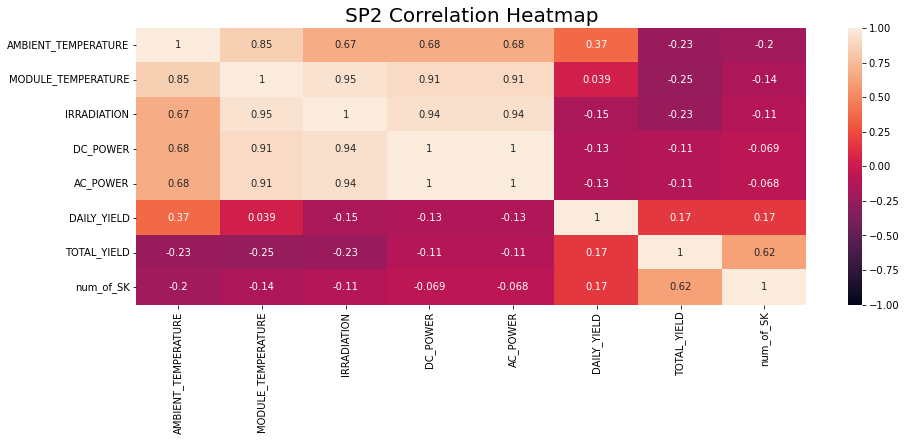

In [74]:
# correlation heatmap for plant 2
PLANT2_DF1_t = PLANT2_DF1.reset_index()
PLANT2_DF1_t = PLANT2_DF1_t.drop('DATE_TIME', axis=1)

sns.heatmap(PLANT2_DF1_t.corr(),vmin=-1, vmax=1, annot=True)
fig = plt.gcf()
fig.set_size_inches(15,8)
plt.subplots_adjust(bottom=0.40)
plt.title('SP2 Correlation Heatmap', fontsize=20)
plt.savefig(r"Images\Plant 2 Correlation Heatmap")
plt.show()

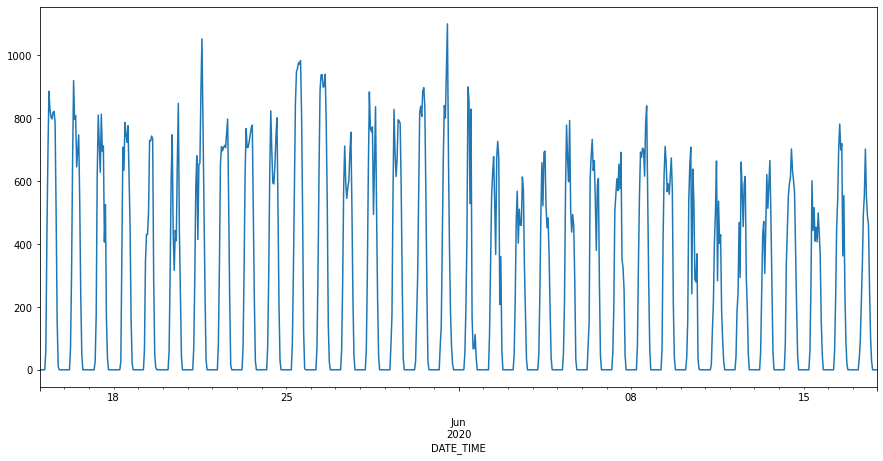

In [75]:
# DC power plot for plant 2
plant2_dcpower = PLANT2_DF1['DC_POWER']
plant2_dcpower.plot(figsize=(15,7))
plt.show()

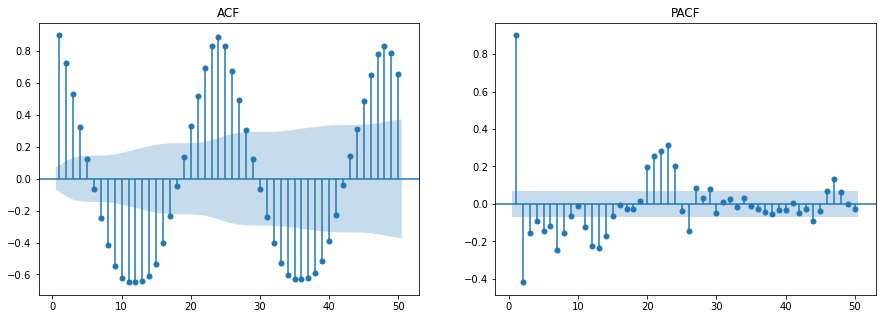

In [76]:
# ACF and PACF for dc power  
fig, ax = plt.subplots(1,2)
plot_acf(plant2_dcpower, zero=False, lags=50, ax=ax[0], title="ACF")
plot_pacf(plant2_dcpower, zero=False,lags=50, ax=ax[1], title="PACF")
fig.set_size_inches(15,5)
plt.savefig(r"Images\AC Power ACF&PACF")
plt.show()

P-value 3.1520525778240088e-18


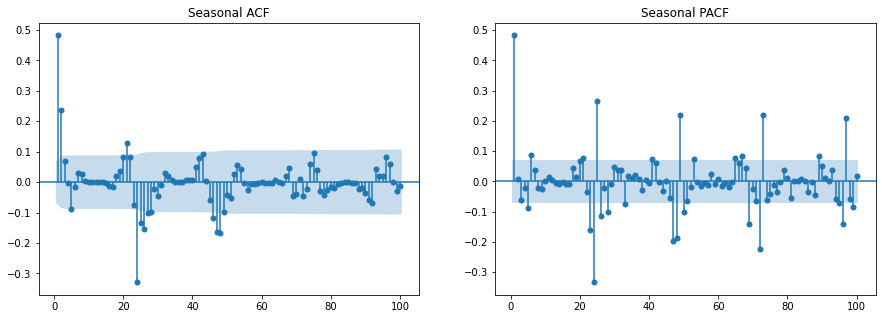

In [77]:
# ACF & PACF of seasonal difference of 24 period
plant2_dcpower_shift_s = plant2_dcpower.diff(24).dropna()
result = adfuller(plant2_dcpower_shift_s.values)
print(f"P-value {result[1]}")

fig, ax = plt.subplots(1,2)
plot_acf(plant2_dcpower_shift_s, zero=False, lags=100, ax=ax[0],title="Seasonal ACF")
plot_pacf(plant2_dcpower_shift_s, zero=False,lags=100, ax=ax[1],title="Seasonal PACF" )
fig.set_size_inches(15,5)
plt.savefig(r"Images\SACF & SPACF")
plt.show()

Choosing Seasonal Parameters: (p:1*,2,3,4 , d:0,1 , q:1*,2)(P:1*,2,3,4 , D:1 , Q:1*,2,3,4, m:24)



In [78]:
#config = [(2,0,2), (4,1,4,24),'t']

Augmented dickey fuller test

 Null Hypothesis (H0): Fail to reject, it suggests the time series has a unit root, meaning
it is non-stationary. It has some time dependent structure.

 Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series
does not have a unit root, meaning it is stationary. It does not have time-dependent
structure.

We interpret this result using the p-value from the test. A p-value below a threshold (such
as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the
threshold suggests we fail to reject the null hypothesis (non-stationary).

 p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is
non-stationary.

 p-value  0.05: Reject the null hypothesis (H0), the data does not have a unit root and
is stationary.

In [79]:
for col in PLANT2_DF1.columns:
    result = adfuller(PLANT2_DF1[col].values)
    print(f'For column {col}, P-value is: {result[1]}')

For column AMBIENT_TEMPERATURE, P-value is: 0.6831309996818269
For column MODULE_TEMPERATURE, P-value is: 0.4593789844396854
For column IRRADIATION, P-value is: 0.06559739329659237
For column DC_POWER, P-value is: 0.0005533852384569639
For column AC_POWER, P-value is: 0.0005238027060265699
For column DAILY_YIELD, P-value is: 0.029603578376713468
For column TOTAL_YIELD, P-value is: 3.557153932407587e-07
For column num_of_SK, P-value is: 0.27832009886383596


In [80]:
# Use summary statistics to show if data is stationary
split = int(len(plant2_dcpower)/2)
part_a , part_b = plant2_dcpower[0:split], plant2_dcpower[split:]
part_a_m, part_b_m = part_a.mean(), part_b.mean()
part_a_v, part_b_v = part_a.var(), part_b.var()
print(f"Part a mean:{part_a_m}, and variance {part_a_v}.")
print(f"Part b mean:{part_b_m}, and variance {part_b_v}.")

Part a mean:278.90863030394763, and variance 115185.45696006752.
Part b mean:218.75018824207825, and variance 70343.43132106353.


The summary statistics above can only mean something if the data is normally distributed.

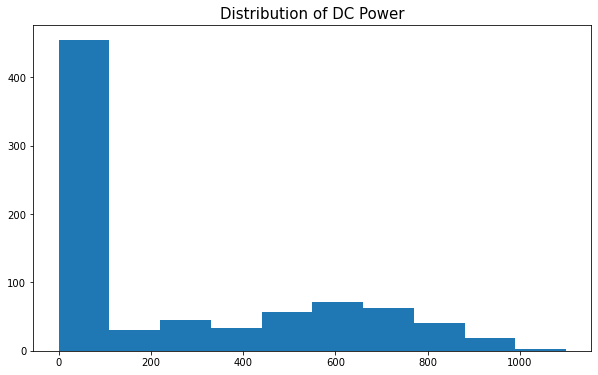

In [386]:
# distribution plot of dc power 
plant2_dcpower.hist(grid=False)
fig = plt.gcf()
fig.set_size_inches(10,6)
plt.title("Distribution of DC Power", fontsize=15)
plt.savefig(r"Images\Distribution of DC Power")
plt.show()

In [82]:
#check if data is stationary. Use augmented dickey fuller test. make sure it is stationary before modelling.
# chapter 14 and 15
result = adfuller(plant2_dcpower.values)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.244545
p-value: 0.000553
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


From the augmented dickey fuller test we can see that every feature in the dataset is stationary, However we know this is not the case looking at the plots. 

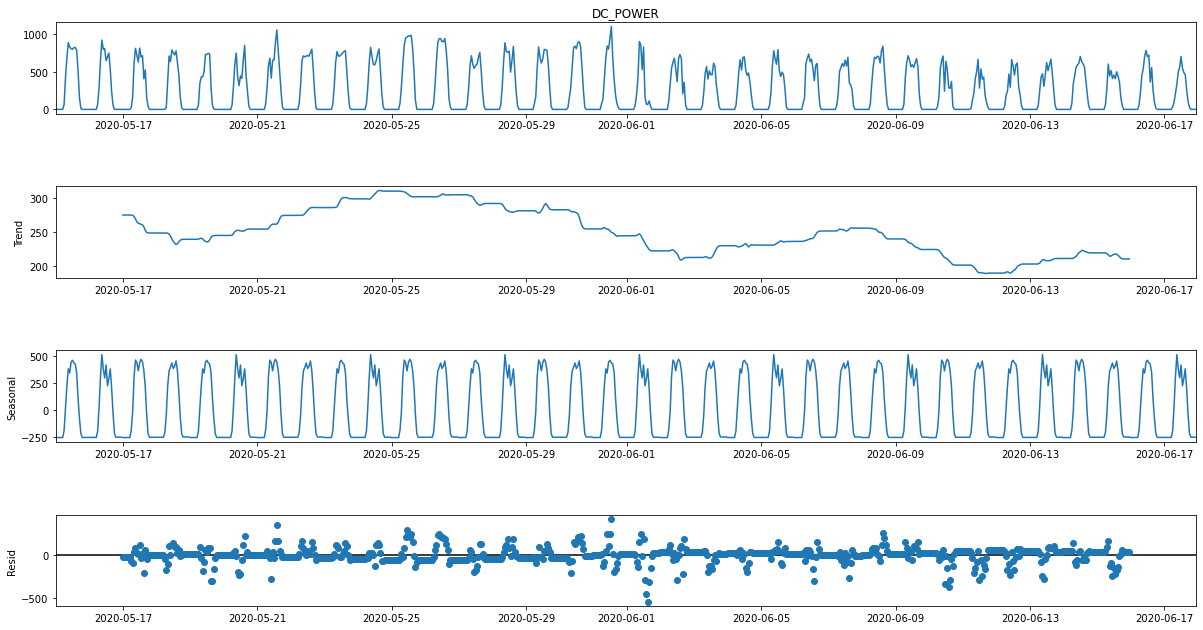

In [83]:
result = seasonal_decompose(plant2_dcpower, model='add', freq=96)
result.plot()
fig = plt.gcf()
fig.set_size_inches(20,10)
plt.savefig(r"Images\seasonal decompose")
plt.show()

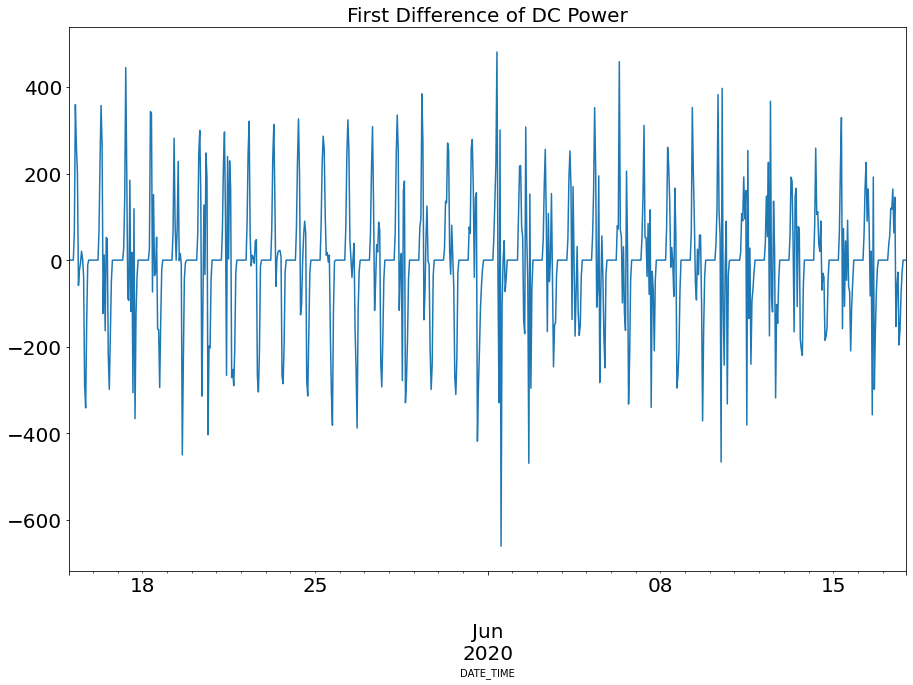

In [84]:
# Taking the first difference of the series should make it stationary.
plant2_dcpower_dif = plant2_dcpower.diff().dropna()
plant2_dcpower_dif.plot(figsize=(15,10), fontsize=20)
plt.title("First Difference of DC Power", fontsize=20)
plt.savefig(r"Images\first diff acpower")
plt.show()

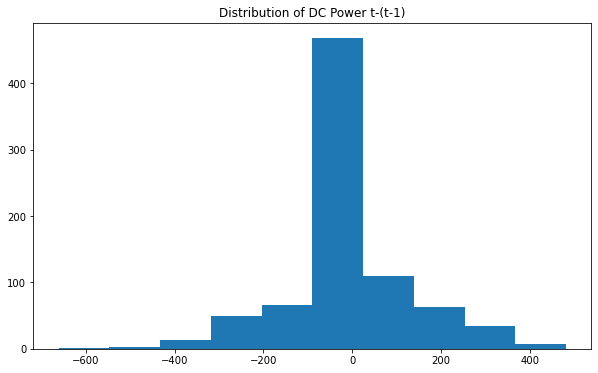

In [385]:
# plot of first difference of dc power 
plant2_dcpower_dif.hist(grid=False)
fig = plt.gcf()
fig.set_size_inches(10,6)
plt.title("Distribution of DC Power t-(t-1)")
plt.savefig(r"Images\Distribution of first difference AC Power")
plt.show()

The above plot looks stationary now with a normal distribution.

Modelling

In [86]:
# build a persistence model to have a basline to compare with all models. 
# As our goal is to predict the 2 days. We will take two days from the end of the dataset and keep it for testing.
def train_test_split(data, test_len=48):
    train, test = data[:-test_len], data[-test_len:]
    return train, test

A persistence model is computed to give a threshold for other models as if a model has a MSE greater than the persistence model is can be considered substandard.

In [365]:
#Persistence model results
train, test = train_test_split(plant2_dcpower)
history = [i for i in train]
pred = []

if __name__ == '__main__':
    start_time = time()
    for i in range(len(test)):
        yhat = history[-1]
        pred.append(yhat)
        history.append(test[i])
    
    time_len = time() - start_time


mse = mean_squared_error(test, pred)
rmse = sqrt(mean_squared_error(test, pred))
print(f'Persistence runtime: {round(time_len/60,3)} mins')    
print(f"Mean Squared Error {round(mse,1)} \nRoot Mean Squared Error {round(rmse,1)}")

Persistence runtime: 0.0 mins
Mean Squared Error 12503.5 
Root Mean Squared Error 111.8


In [88]:
# create multiple differenct configurations to grid search over
import itertools

def sarima_configs():
#     p,d,q = [0,1,2,3,4,5,6], [0,1], [0,1,2,3,4] # p: From ACF plot 1-4, d: first order difference, q: from pacf plot
#     P,D,Q = [0,1,2,3,4], [0,1], [0,1,2]
#     m = 24
#     ts = ['n', 'c', 't', 'ct']
    
    p,d,q = [2], [1], [4,5,6] # p: From ACF plot 1-4, d: first order difference, q: from pacf plot
    P,D,Q = [2], [1], [6,7,8] 
    m = 24
    ts = ['n']
    # p =2, d=0, q=4,5,6
    # P=2, D=1, Q=6,7,8
    #ts = 'n'
    
    pdq = list(itertools.product(p,d,q))
    pdqs = list(itertools.product(P,D,Q))

    pdqs = [(c[0], c[1], c[2], m) for c in pdqs]
    
    models = []
    for odr in pdq:
        for sodr in pdqs:
            for t in ts:
                models.append([odr, sodr, t])
    return models
    
models = sarima_configs()
print(f"{len(models)}\n")
for model in models:
    print(model)


9

[(2, 0, 4), (2, 1, 6, 24), 'n']
[(2, 0, 4), (2, 1, 7, 24), 'n']
[(2, 0, 4), (2, 1, 8, 24), 'n']
[(2, 0, 5), (2, 1, 6, 24), 'n']
[(2, 0, 5), (2, 1, 7, 24), 'n']
[(2, 0, 5), (2, 1, 8, 24), 'n']
[(2, 0, 6), (2, 1, 6, 24), 'n']
[(2, 0, 6), (2, 1, 7, 24), 'n']
[(2, 0, 6), (2, 1, 8, 24), 'n']


# This code below needs to be saved in another .py file in order to work due to a bug with the multiprocess library.

In [89]:
# from multiprocessing import cpu_count
# import multiprocess
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from sklearn.metrics import mean_squared_error
# from warnings import catch_warnings
# from warnings import filterwarnings

# def train_test_split(data):
#     return data[:-48], data[-48:]
    
# def sarima_model(data, cfg):
#     order, s_order, t = cfg[0], cfg[1], cfg[2]
    
#     model = SARIMAX(data, order=order, seasonal_order=s_order, trend=t, 
#                    enforce_stationarity=False, enfore_invertibility=False)

#     model_fit = model.fit(disp=False)

#     yhat = model_fit.predict(len(data))
#     return yhat

# def walk_forward_val(data, cfg):
    
#     train, test = train_test_split(data)
#     pred = []
#     history = [i for i in train] 

    
    
#     #for model in models:
#     for i in range(len(test)):
#         yhat = sarima_model(history, cfg)
#         pred.append(yhat)
#         history.append(test[i])
    
#     mse = mean_squared_error(test, pred)
#     return mse


# def score_model(data, cfg, debug=False):
#     result = None
#     key = str(cfg)
# # show all warnings and fail on exception if debugging
#     if debug:
#         result = walk_forward_val(data, cfg)
#     else:
#     # one failure during model validation suggests an unstable config
#         try:
#     # never show warnings when grid searching, too noisy
#             with catch_warnings():
#                 filterwarnings("ignore")
#                 result = walk_forward_val(data, cfg)
#         except:
#             error = None
#     # check for an interesting result
#     if result is not None:
#         print(' > Model[%s] %.3f' % (key, result))
#     return (key, result)



# def grid_search(data, cfg_list, parallel=True):
#     scores = None
#     if parallel:
#     # execute configs in parallel
#         pool = multiprocess.Pool(cpu_count())
#         processes = [pool.apply_async(score_model, args=(data, cfg)) for cfg in cfg_list]
#         scores = [p.get() for p in processes]
#     else:
#         scores = [score_model(data, cfg) for cfg in cfg_list]
    
#     scores = [r for r in scores if r[1] != None]
#     scores.sort(key=lambda x: x[1])
#     return scores

# -------------------------------------------------------

In [90]:
# from gs import grid_search

# def test_run_sarima(data):
#     models = sarima_configs()
#     scores = grid_search(data, models, parallel=True)
#     return scores

# gs_df = plant2_acpower[:24*8]

# if __name__ == '__main__':
#     scores = test_run_sarima(gs_df)
#     print('Done')

In [91]:
# data = np.array(scores)
# data_df = pd.DataFrame(data, columns=['Models','MSE'])
# data_df.to_csv('MSE_scores_extend.csv', index=False)

In [94]:
# import ast
# from gs import grid_search

# scores = pd.read_csv('Model_Scores.csv')
# scores = scores.sort_values('MSE', axis=0, ascending=True)
# scores = scores.astype({'Models':'category'})

# t_models = pd.Series(scores['Models'][:9]).tolist()
# t_models_list = []

# for i in range(9):
#     t_models_list.append(ast.literal_eval(t_models[i]))
    
# def test_run_sarima(data):
#     scores = grid_search(data, t_models_list)
#     return scores

# if __name__ == '__main__':
#     scores = test_run_sarima(plant1_acpower)
#     print('Done')

# save_file_csv(scores, 'Final_Scores.csv')

SARIMA model takes apprx 180 mins to run, hence why most of the code is commented.

In [95]:
from time import time
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

configg = [(2, 1, 4), (2, 1, 6, 24), 'n']

def train_test_split(data, test_len=48):
    """
    Split data into training and testing.
    """
    train, test = data[:-test_len], data[-test_len:]
    return train, test

def sarima_model(data, cfg, test_len, i):
    """
    SARIMA model which outputs prediction and model. 
    """
    order, s_order, t = cfg[0], cfg[1], cfg[2]
    model = SARIMAX(data, order=order, seasonal_order=s_order, trend=t, 
                   enforce_stationarity=False, enfore_invertibility=False)
    model_fit = model.fit(disp=False)
    yhat = model_fit.predict(len(data))
    
    if i + 1 == test_len:
        return yhat, model_fit
    else:
        return yhat

def walk_forward_val(data, cfg):
    """
    A walk forward validation technique used for time series data. Takes current value of x_test and predicts 
    value. x_test is then fed back into history for the next prediction.
    """
    train, test = train_test_split(data)
    pred = []
    history = [i for i in train] 
    test_len = len(test)
    
    for i in range(test_len):
        if i + 1 == test_len:
            yhat, s_model = sarima_model(history, cfg, test_len, i)
            pred.append(yhat)
            mse = mean_squared_error(test, pred)
            return pred, mse, s_model
        else:
            yhat = sarima_model(history, cfg, test_len, i)
            pred.append(yhat)
            history.append(test[i])
    pass 

# if __name__ == '__main__':
#     start_time = time()
#     sarima_pred_plant2, sarima_mse, s_model = walk_forward_val(plant2_dcpower, configg)
#     time_len = time() - start_time

#     print(f'SARIMA runtime: {round(time_len/60,2)} mins')

In [ ]:
# s_model.plot_diagnostics()
# fig = plt.gcf()
# fig.set_size_inches(20,10)
# plt.show()

In [96]:
## used to save model
# def __getnewargs__(self):
# 	return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))
# ARIMA.__getnewargs__ = __getnewargs__

# s_model.save('SARIMA_Model.pkl')

In [97]:
# train, test = train_test_split(plant2_dcpower)

# sarima_pred_p2 = pd.DataFrame(test)
# sarima_pred_p2['SARIMA'] = np.array(sarima_pred_plant2).flatten()
# sarima_pred_p2.plot()
# fig = plt.gcf()
# fig.set_size_inches(20,10)
# plt.title("SARIMA Prediction MSE: 5447.05")
# plt.ylabel("AC Power (kW)")
# plt.xlabel("DateTime")
# plt.savefig(r"Images\SARIMA Prediction")
# plt.show()

In [98]:
#sarima_pred_p2.to_csv("SARIMA_results.csv")

SARIMA Results

In [99]:
SARIMA = ARIMAResults.load('SARIMA_Model.pkl')

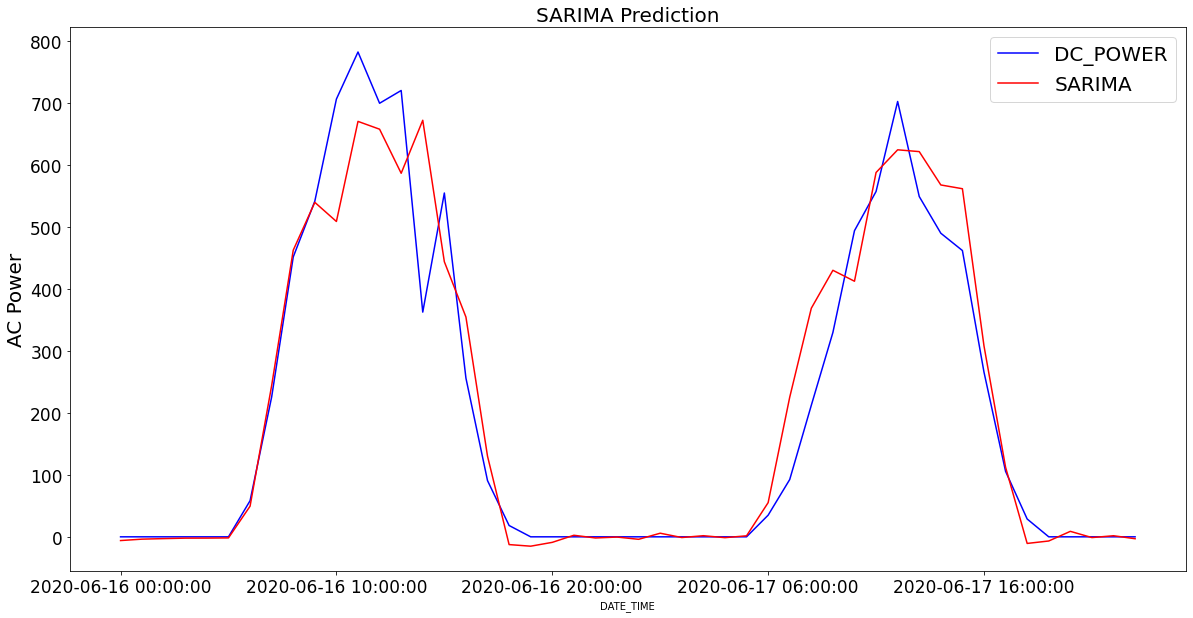

5898.796601339112


In [100]:
train, test = train_test_split(plant2_dcpower)

sarima_pred_saved = pd.read_csv('SARIMA_Results.csv', index_col=['DATE_TIME'])
sarima_pred_saved = sarima_pred_saved.rename(columns={"Actual":"DC_POWER"})
#col = pd.Series(['DC_POWER','SARIMA'], index=[])
sarima_pred_saved.plot(color=['b','r'], fontsize=17)
fig = plt.gcf()
fig.set_size_inches(20,10)
plt.legend(loc=1,prop={'size': 20})
plt.title("SARIMA Prediction", fontsize=20)
plt.ylabel("AC Power",fontsize=20)
plt.savefig(r"Images\SARIMA Prediction")
plt.show()

print(mean_squared_error(sarima_pred_saved['DC_POWER'], sarima_pred_saved['SARIMA']))

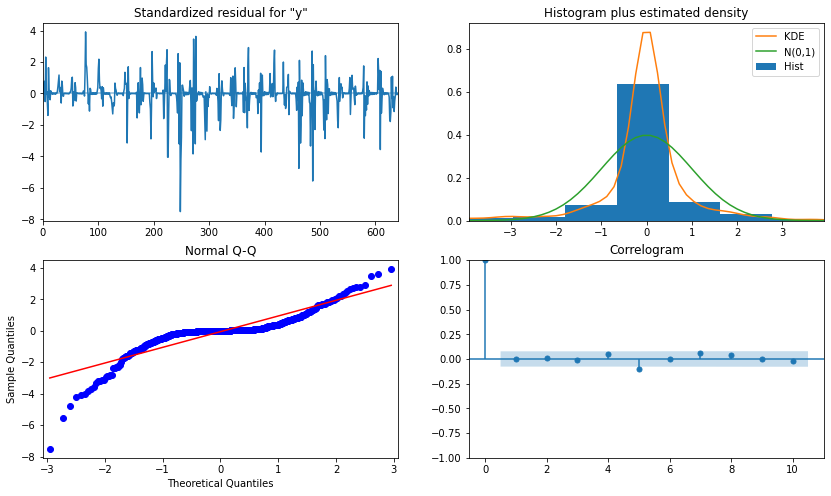

In [101]:
SARIMA.plot_diagnostics()
fig = plt.gcf()
fig.set_size_inches(14,8)
plt.savefig(r"Images\SARIMA Diagnostics")
plt.show()

When looking at the diagnostics of the residulas, we can tell if our model is a good fit if 

1) the residuals are uncorrelated. If there are correlations between residuals  then there is information left in the residuals which should be used in computing forecasts.

2) The residuals have a zero mean. If the residuals have a mean other than zero, then the forecast are biased.

In addition, it is useful for the residuals to also ahve a constant variance and are normally distributed.

<font color='red'>XGBOOST</font>

In [102]:
# GRID SEARCH XGBOOST MODELS
def xgb_configs():
    """
    Configurations used for XGBOOST model.
    """
    learning_rate = [0.005, 0.01, 0.05, 0.1]
    n_estimators = [800, 1000,1200]
    subsample = [0.7,0.8,0.9, 1]
    colsample_bytree = [0.9,1]
    colsample_bylevel = [0.9,1]
    min_child_weight = [1,10, 20, 30]
    max_depth = [4,6,8,10,12]
    
    configs = list(itertools.product(learning_rate,n_estimators, subsample,
                                     colsample_bytree, colsample_bylevel, 
                                     min_child_weight,max_depth))
    return configs
    
models = xgb_configs()
print(f"Number of XGBOOST configurations: {len(models)}")

Number of XGBOOST configurations: 3840


# Code below is commented out as it grid searches over the different configurations

In [103]:
# from xgb_gs import grid_search

# def test_run_xgb(data):
#     configs = xgb_configs()
#     scores = grid_search(data, configs, parallel=True)
#     return scores

# #gs_df = plant2_acpower[:24*8]

# if __name__ == '__main__':
#     xgb_scores = test_run_xgb(PLANT2_DF1)
#     print('Done')



In [104]:
# data = np.array(xgb_scores)
# data_df = pd.DataFrame(data, columns=['xgb_models','MSE'])
# data_df.head(10)
#data_df.to_csv('XGBOOST_MSE.csv', index=False)

# ----------------------------------------------------------

In [105]:
# WITHOUT SCALING 
# def train_test_split(df, test_len=48):
#     train, test = df[:-test_len], df[-test_len:]
#     return train, test

# def data_to_supervised(df, shift_by=1, target_var='DC_POWER'):
#     target = df[target_var][shift_by:].values
#     dep = df.drop(target_var, axis=1).shift(-shift_by).dropna().values
#     data = np.column_stack((dep, target))
#     return data


# def xgb_forecast(train, x_test):
#     x_train, y_train = train[:,:-1], train[:,-1]
#     xgb_model = xgb.XGBRegressor(learning_rate=0.01, n_estimators=1200, subsample=0.8,
#                                  colsample_bytree=1,colsample_bylevel=1,
#                                  min_child_weight=20, max_depth=10, objective='reg:squarederror')
#     xgb_model.fit(x_train, y_train)
#     yhat = xgb_model.predict([x_test])
#     return yhat[0], xgb_model

# def walk_forward_validation(df):
#     preds = []
#     train, test = train_test_split(df)
#     train, test = data_to_supervised(train), data_to_supervised(test)
#     history = np.array([x for x in train])
    
#     for i in range(len(test)):
#         test_x, test_y = test[i][:-1], test[i][-1]
#         yhat, xgb_model = xgb_forecast(history, test_x)
#         preds.append(yhat)
#         np.append(history,[test[i]], axis=0)
#         print(f"Actual: {test_y}, Predicted: {yhat}")
#     err = mean_squared_error(test[:,-1], preds)
#     return err, preds, test[:,-1], xgb_model

# ++++++++++++++++++++++++++++

In [362]:
import numpy as np 
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from time import time

def train_test_split(df, test_len=48):
    """
    split data into training and testing.
    """
    train, test = df[:-test_len], df[-test_len:]
    return train, test

def data_to_supervised(df, shift_by=1, target_var='DC_POWER'):
    """
    Convert data into a supervised learning problem.
    """
    target = df[target_var][shift_by:].values
    dep = df.drop(target_var, axis=1).shift(-shift_by).dropna().values
    data = np.column_stack((dep, target))
    return data


def xgb_forecast(train, x_test):
    """
    XGBOOST model which outputs prediction and model.
    """
    x_train, y_train = train[:,:-1], train[:,-1]
    xgb_model = xgb.XGBRegressor(learning_rate=0.01, n_estimators=1500, subsample=0.8,
                                 colsample_bytree=1, colsample_bylevel=1,
                                 min_child_weight=20, max_depth=14, objective='reg:squarederror')
    xgb_model.fit(x_train, y_train)
    yhat = xgb_model.predict([x_test])
    return yhat[0], xgb_model

def walk_forward_validation(df):
    """
    A walk forward validation approach by scaling the data and changing into a supervised learning problem.
    """
    preds = []
    train, test = train_test_split(df)
    
    scaler = MinMaxScaler(feature_range=(0,1))
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)
    
    train_scaled_df = pd.DataFrame(train_scaled, columns = train.columns, index=train.index)
    test_scaled_df = pd.DataFrame(test_scaled, columns = test.columns, index=test.index)
    
    train_scaled_sup, test_scaled_sup = data_to_supervised(train_scaled_df), data_to_supervised(test_scaled_df)
    history = np.array([x for x in train_scaled_sup])
    
    for i in range(len(test_scaled_sup)):
        test_x, test_y = test_scaled_sup[i][:-1], test_scaled_sup[i][-1]
        yhat, xgb_model = xgb_forecast(history, test_x)
        preds.append(yhat)
        np.append(history,[test_scaled_sup[i]], axis=0)
        
    pred_array = test_scaled_df.drop("DC_POWER", axis=1).to_numpy()
    pred_num = np.array([pred])
    pred_array = np.concatenate((pred_array, pred_num.T), axis=1)
    result = scaler.inverse_transform(pred_array)
    
    return result, test, xgb_model

# if __name__ == '__main__':
#     start_time = time()
#     xgb_pred, actual, xgb_model = walk_forward_validation(dropped_df_cat)
#     time_len = time() - start_time

#     print(f'XGBOOST runtime: {round(time_len/60,2)} mins')

XGBOOST runtime: 1.43 mins


In [341]:
# create a dataframe of a lag of 1 hour
plant2_df1_ac = PLANT2_DF1[["AC_POWER","DC_POWER"]]
plant2_df1_ac["EFF"] = plant2_df1_ac["AC_POWER"] / plant2_df1_ac["DC_POWER"]
plant2_df1_ac.fillna(0, inplace=True)
plant2_df1_ac = plant2_df1_ac.shift(1)
plant2_df1_ac.columns = ["S1_AC_POWER","S1_DC_POWER","EFF"]

In [342]:
# drop columns which can lead to data leakage and those which are poorly correlated.
dropped_df = PLANT2_DF1.drop(['num_of_SK','AC_POWER', "MODULE_TEMPERATURE"],axis=1)
dropped_df["HOUR"] = dropped_df.index.hour

In [343]:
# concatenate both dataframes which will be used for modeliing 
dropped_df_cat = pd.concat([dropped_df, plant2_df1_ac], axis=1).dropna()
dropped_df_cat.head()

AMBIENT_TEMPERATURE  IRRADIATION  DC_POWER   DAILY_YIELD  \
DATE_TIME                                                                       
2020-05-15 01:00:00            26.505909      0.00000       0.0  83444.000000   
2020-05-15 02:00:00            26.296562      0.00000       0.0  75904.000000   
2020-05-15 03:00:00            26.141691      0.00000       0.0  75537.666667   
2020-05-15 04:00:00            25.509473      0.00000       0.0  53924.000000   
2020-05-15 05:00:00            24.966926      0.00071       0.0  27904.380952   

                      TOTAL_YIELD  HOUR  S1_AC_POWER  S1_DC_POWER  EFF  
DATE_TIME                                                               
2020-05-15 01:00:00  5.675838e+10     1          0.0          0.0  0.0  
2020-05-15 02:00:00  5.675838e+10     2          0.0          0.0  0.0  
2020-05-15 03:00:00  5.675838e+10     3          0.0          0.0  0.0  
2020-05-15 04:00:00  5.675838e+10     4          0.0          0.0  0.0  
2020-05-15 05:00:00  5.659767e+10     5          0.0          0.0  0.0

In [344]:
# run XGBOOST model
xgb_pred, actual, xgb_model = walk_forward_validation(dropped_df_cat)

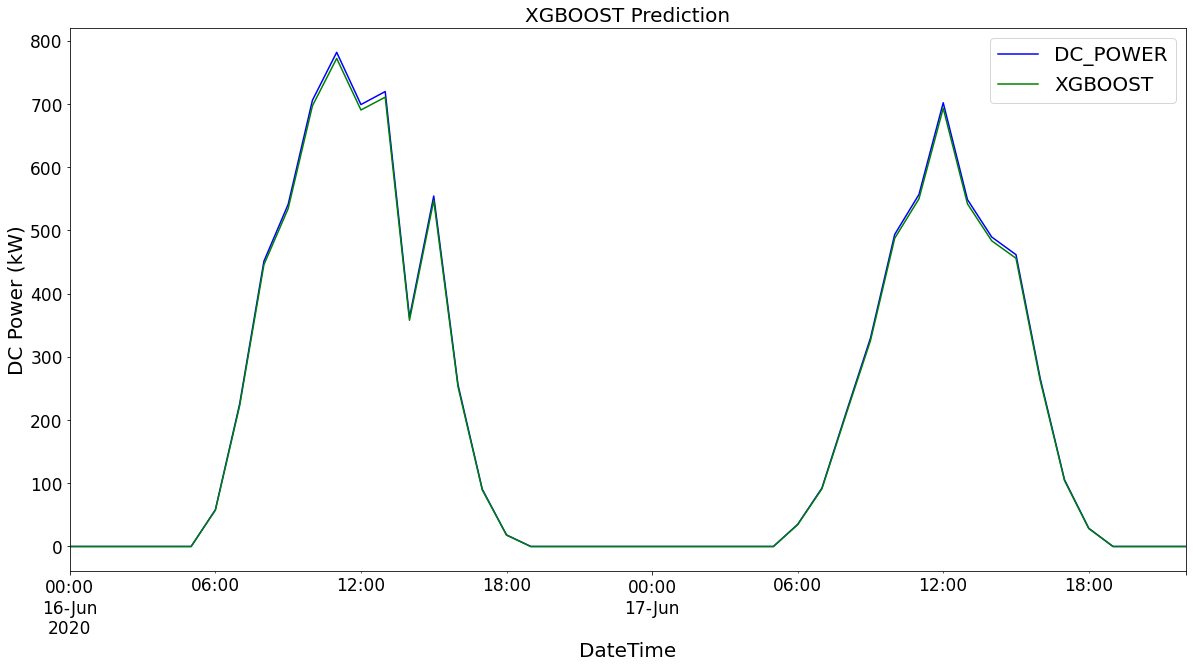

In [345]:
train, test = train_test_split(PLANT2_DF1)
ac_power_test_xgb = test[['DC_POWER']][:-1]
ac_power_test_xgb['XGBOOST'] = xgb_pred[1:,-1]

ac_power_test_xgb.plot(legend=True, color=['b','g'], fontsize=17)
fig = plt.gcf()
fig.set_size_inches(20,10)
plt.legend(loc=1,prop={'size': 20})
plt.title("XGBOOST Prediction", fontsize=20)
plt.ylabel("DC Power (kW)", fontsize=20)
plt.xlabel("DateTime", fontsize=20)
plt.savefig(r"Images\XGBOOST Prediction")
plt.show()

In [346]:
# print MSE of XGBOOST model.
xgb_mse = mean_squared_error(ac_power_test_xgb['DC_POWER'], ac_power_test_xgb['XGBOOST'])
print(xgb_mse)

16.89587600948177


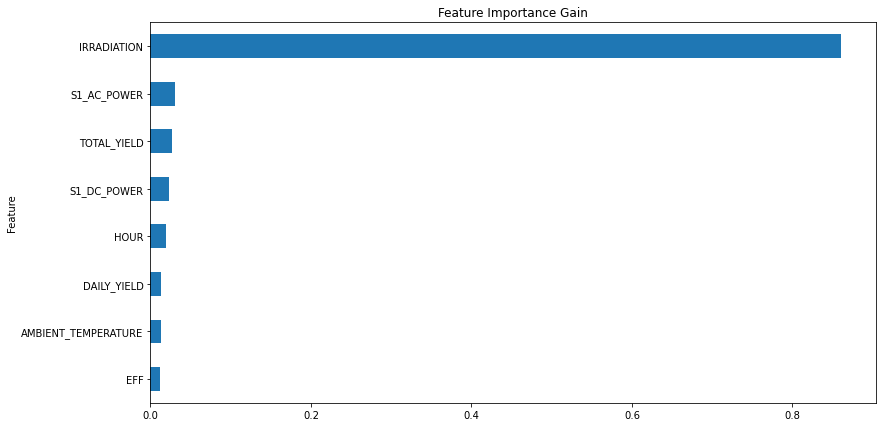

In [347]:
# create featureimportance plot of xgboost model.GAIN
dropped_df_fi = dropped_df_cat.drop('DC_POWER', axis=1).columns
FI = pd.DataFrame({"Feature": dropped_df_fi, "Importance":xgb_model.feature_importances_}).set_index("Feature")     
FI = FI.sort_values("Importance")

FI.plot(kind='barh', legend=False, figsize=(13,7))
plt.title("Feature Importance Gain")
plt.savefig(r"Images\XGBOOST_Feat_Imp")
plt.show()

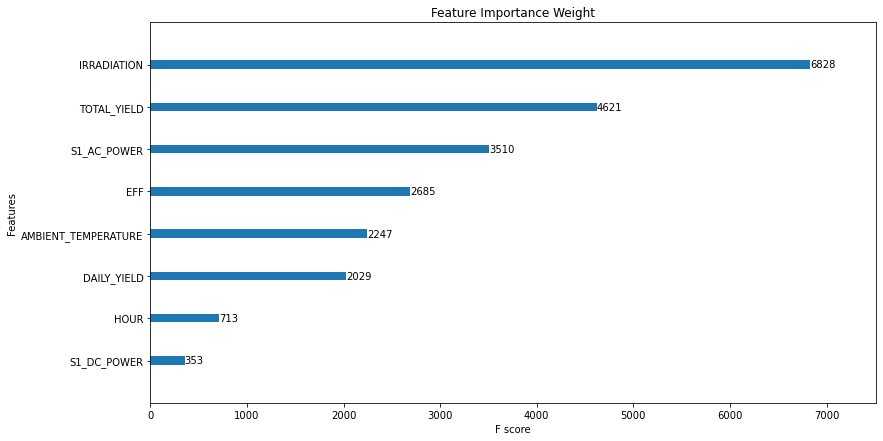

In [348]:
# plot F-score for each feature WEIGHT
scores = xgb_model.get_booster().get_score()
sorted_scores = sorted(scores.items(), reverse=True, key=lambda item: item[1])
feature_index = list(dict(sorted_scores).keys())
feature_index = [int(idx[1]) for idx in feature_index]
res_list = [dropped_df_fi[i] for i in feature_index][::-1]

ax = xgb.plot_importance(xgb_model, grid=False)
ax.set_yticklabels(res_list)
fig = plt.gcf()
fig.set_size_inches(13,7)
plt.title("Feature Importance Weight")
plt.savefig(r"Images\XGBOOST_F_score")
plt.show()

<font color='red'>Deep Learning CNN-LSTM</font>

In [349]:
PLANT2_DF1.head()

AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  \
DATE_TIME                                                                   
2020-05-15 00:00:00            26.767055           24.582656          0.0   
2020-05-15 01:00:00            26.505909           25.172109          0.0   
2020-05-15 02:00:00            26.296562           24.555514          0.0   
2020-05-15 03:00:00            26.141691           24.627655          0.0   
2020-05-15 04:00:00            25.509473           24.658230          0.0   

                     DC_POWER  AC_POWER    DAILY_YIELD   TOTAL_YIELD  \
DATE_TIME                                                              
2020-05-15 00:00:00       0.0       0.0  134102.938095  5.675838e+10   
2020-05-15 01:00:00       0.0       0.0   83444.000000  5.675838e+10   
2020-05-15 02:00:00       0.0       0.0   75904.000000  5.675838e+10   
2020-05-15 03:00:00       0.0       0.0   75537.666667  5.675838e+10   
2020-05-15 04:00:00       0.0       0.0   53924.000000  5.675838e+10   

                     num_of_SK  
DATE_TIME                       
2020-05-15 00:00:00       22.0  
2020-05-15 01:00:00       22.0  
2020-05-15 02:00:00       22.0  
2020-05-15 03:00:00       22.0  
2020-05-15 04:00:00       22.0

In [350]:
def train_test_split(df, test_len=48):
    """
    Split data in training and testing. Use 48 hours as testing.
    """
    train, test = df[:-test_len], df[-test_len:]
    return train, test

def split_data(sequences, n_steps):
    """
    Preprocess data returning two arrays.
    """
    x, y = [], []
    for i in range(len(sequences)):
        end_x = i + n_steps
        
        if end_x > len(sequences):
            break
        x.append(sequences[i:end_x, :-1]) 
        y.append(sequences[end_x-1, -1])
        
    return np.array(x), np.array(y)

In [351]:
# split data and reshape ORIGINAL
train, test = train_test_split(dropped_df_cat)  

train_x = train.drop(columns="DC_POWER", axis=1).to_numpy()
train_y = train["DC_POWER"].to_numpy().reshape(len(train), 1)

test_x = test.drop(columns="DC_POWER", axis=1).to_numpy()
test_y = test["DC_POWER"].to_numpy().reshape(len(test), 1)

In [352]:
#scale data  ORIGINAL
scaler_x = MinMaxScaler(feature_range=(-1,1))
scaler_y = MinMaxScaler(feature_range=(-1,1))

train_x = scaler_x.fit_transform(train_x)
train_y = scaler_y.fit_transform(train_y) 

test_x = scaler_x.transform(test_x)
test_y = scaler_y.transform(test_y)

In [353]:
n_steps = 1
subseq = 1

train_data_np = np.hstack((train_x, train_y))
x, y = split_data(train_data_np, n_steps)
x_subseq = x.reshape(x.shape[0], subseq, x.shape[1], x.shape[2])

In [354]:
# shape data into CNN-LSTM format [samples, subsequences, timesteps, features] ORIGINAL
n_steps = 1
subseq = 1

train_data_np = np.hstack((train_x, train_y))
x, y = split_data(train_data_np, n_steps)
x_subseq = x.reshape(x.shape[0], subseq, x.shape[1], x.shape[2])

In [355]:
# check shape of data
x_val, y_val = x_subseq[-24:], y[-24:]
x_train, y_train = x_subseq[:-24], y[:-24]
print(x_val.shape)
print(y_val.shape)
print(x_train.shape)
print(y_train.shape)

(24, 1, 1, 8)
(24,)
(743, 1, 1, 8)
(743,)


In [356]:
# CNN_LSTM model
def CNN_LSTM(x, y, x_val, y_val):
    """
    CNN-LSTM model.
    """
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=14, kernel_size=1, activation="sigmoid", 
                                     input_shape=(None, x.shape[2], x.shape[3]))))
    model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(21, activation="tanh", return_sequences=True))
    model.add(LSTM(14, activation="tanh", return_sequences=True))
    model.add(LSTM(7, activation="tanh"))
    model.add(Dense(3, activation="sigmoid"))
    model.add(Dense(1))
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=['mse'])
    history = model.fit(x, y, epochs=250, batch_size=36,
                        verbose=0, validation_data=(x_val, y_val))
    
    return model, history

In [374]:
# run CNN-LSTM model ORIGINAL 
n_features = x.shape[2]
actual = scaler_y.inverse_transform(test_y)

if __name__ == '__main__':
    start_time = time()

    model, history = CNN_LSTM(x_train, y_train, x_val, y_val)
    prediction = []
    
    for i in range(len(test_x)):
        test_input = test_x[i].reshape(1, subseq, n_steps, n_features)
        yhat = model.predict(test_input, verbose=0)
        yhat_IT = scaler_y.inverse_transform(yhat)
        prediction.append(yhat_IT[0][0])

    time_len = time() - start_time
    mse = mean_squared_error(actual.flatten(), prediction)
    
    print(f'CNN-LSTM runtime: {round(time_len/60,2)} mins')
    print(f"CNN-LSTM MSE: {round(mse,2)}")

CNN-LSTM runtime: 0.82 mins
CNN-LSTM MSE: 1652.24


In [124]:
# due to the stochastic nature of CNN-LSTM, the model is run 10 times to find a mean score.
mean_mse = []
actual = scaler_y.inverse_transform(test_y)
for j in range(10):
    model, history = CNN_LSTM(x_train, y_train, x_val, y_val)
    prediction = []
    for i in range(len(test_x)):
        test_input = test_x[i].reshape(1, subseq, n_steps, n_features)
        yhat = model.predict(test_input, verbose=0)
        yhat_IT = scaler_y.inverse_transform(yhat)
        prediction.append(yhat_IT[0][0])
    mean_mse.append(mean_squared_error(actual.flatten(), prediction))
    print(j)

0
1
2
3
4
5
6
7
8
9


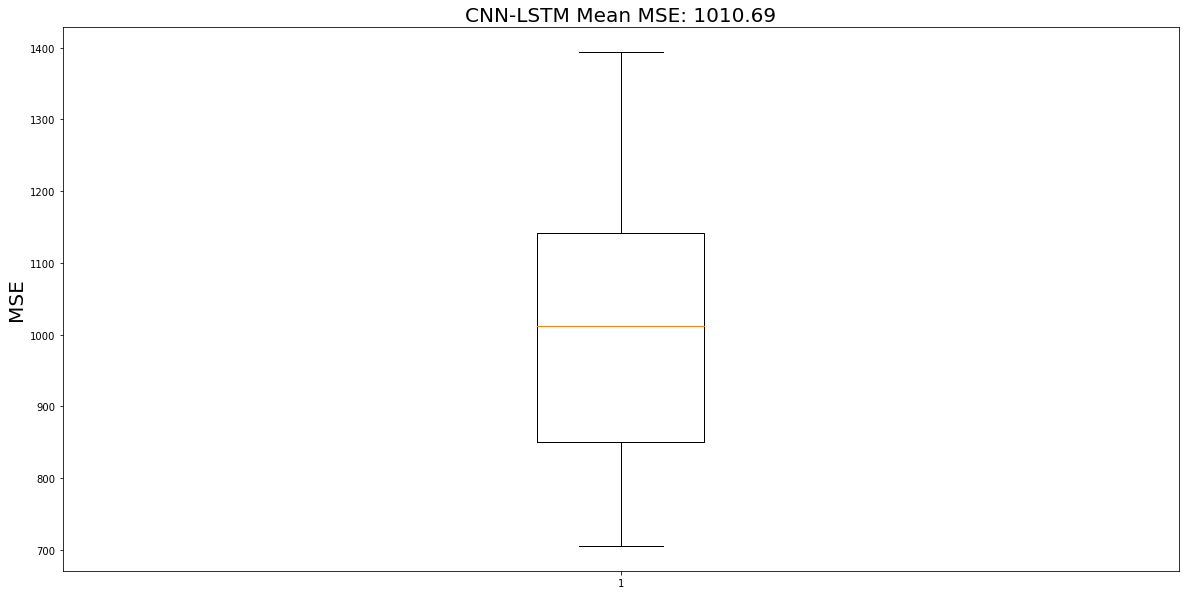

In [125]:
# plot mean score
mean_mses = sum(mean_mse)/len(mean_mse)

plt.boxplot(mean_mse)
fig = plt.gcf()
fig.set_size_inches(20,10)
plt.ylabel("MSE", fontsize=20)
plt.title(f"CNN-LSTM Mean MSE: {round(mean_mses,2)}", fontsize=20)
plt.savefig(r"Images\CNN-LSTM Mean")
plt.show()

In [358]:
# model summary
print(model.summary())

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_58 (TimeDis (None, 1, 1, 14)          126       
_________________________________________________________________
time_distributed_59 (TimeDis (None, 1, 1, 14)          0         
_________________________________________________________________
time_distributed_60 (TimeDis (None, 1, 14)             0         
_________________________________________________________________
lstm_58 (LSTM)               (None, 1, 21)             3024      
_________________________________________________________________
lstm_59 (LSTM)               (None, 1, 14)             2016      
_________________________________________________________________
lstm_60 (LSTM)               (None, 7)                 616       
_________________________________________________________________
dense_39 (Dense)             (None, 3)               

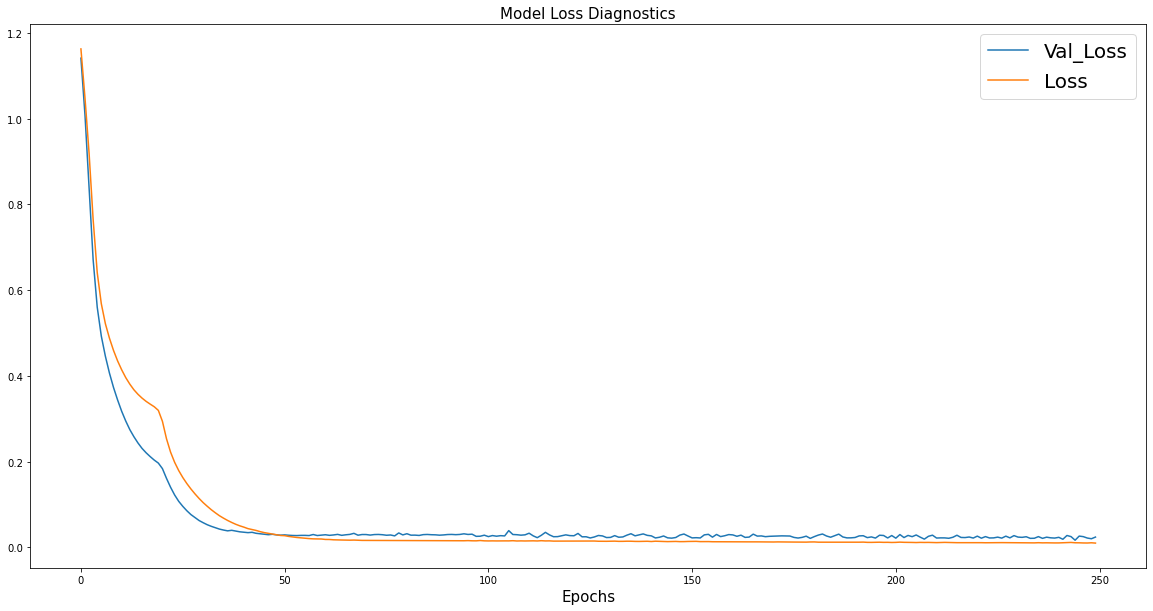

In [361]:
#plot validation loss
plt.plot(history.history["val_loss"][0:], label='Val_Loss')
plt.plot(history.history['loss'][0:], label='Loss')
fig = plt.gcf()
fig.set_size_inches(20,10)
plt.legend()
plt.xlabel("Epochs", fontsize=15)
#plt.ylabel("MSE", fontsize=15)
plt.legend(loc=1,prop={'size': 20})
plt.title("Model Loss Diagnostics", fontsize=15)
plt.savefig(r"Images\CNN-LSTM loss diag")
plt.show()

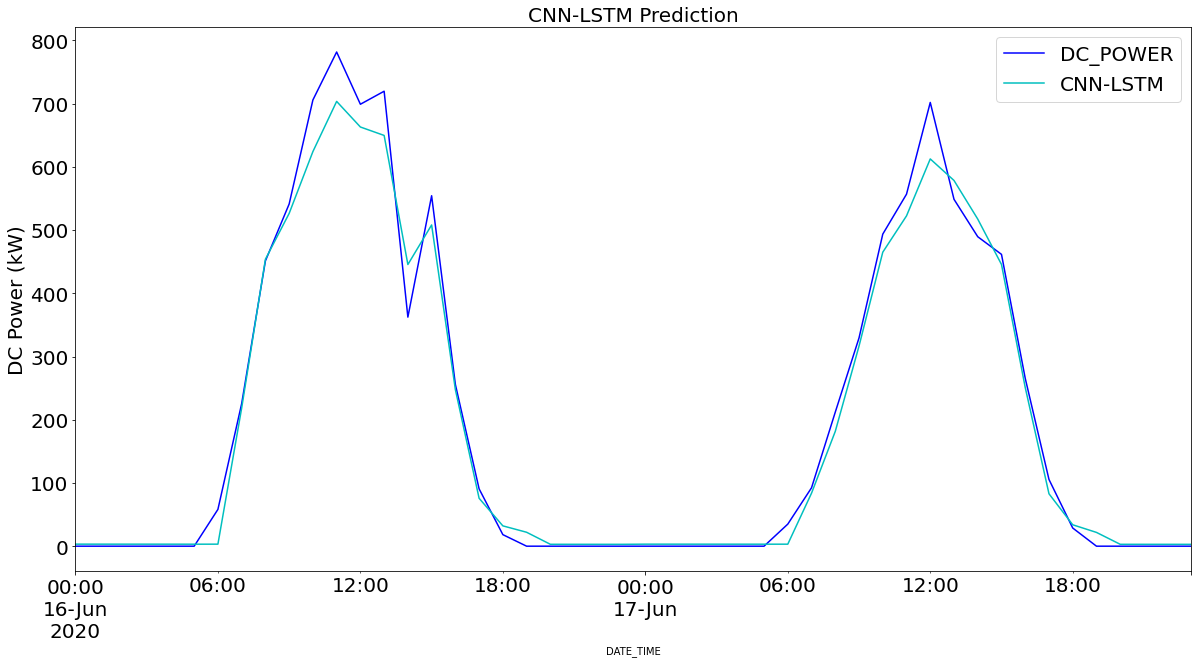

MSE of CNN-LSTM: 995.31


In [360]:
# plot CNN-LSTM results
cnn_lstm = pd.DataFrame(test['DC_POWER'])
cnn_lstm['CNN-LSTM'] = prediction

cnn_lstm_mse = mean_squared_error(cnn_lstm['DC_POWER'], cnn_lstm['CNN-LSTM'])

cnn_lstm.plot(color=['b','c'], fontsize=20)
fig = plt.gcf()
fig.set_size_inches(20,10)
plt.legend(loc=1,prop={'size': 20})
plt.title(f"CNN-LSTM Prediction", fontsize=20)
plt.ylabel("DC Power (kW)", fontsize=20)
plt.xlabel("DateTime")
plt.savefig(r"Images\CNN-LSTM Prediction")
plt.show()
print(f"MSE of CNN-LSTM: {cnn_lstm_mse.round(2)}")